In [1]:
import io
import os
import re
import unidecode
import math
import time
import unidecode
import queue
import paramiko
import soundfile as sf
import pydub
import time
import pandas as pd
import numpy as np

from random import shuffle
from random import choice

from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from sklearn.externals import joblib

from millenlp.preprocessing import PreProc
from millenlp.embeddings import FastTextVec, TfidfVec, BertVec
from millenlp.state_models.shallow_model import ShallowModel

from bokeh.plotting import figure, output_notebook, show, ColumnDataSource, output_file
from bokeh.palettes import Blues9,Spectral11,Category10,Set1,Set2,Category20
from bokeh.io import reset_output
from bokeh.models import BoxSelectTool,CustomJS, ColumnDataSource, Legend

from graphviz import Digraph

import matplotlib.pyplot as plt

from pydub import AudioSegment
from threading import Thread
# from google.cloud.speech import enums
# from google.cloud import speech
# from google.cloud.speech import types
# from google.cloud import storage

I1107 00:20:34.535539 139688769197888 file_utils.py:39] PyTorch version 1.2.0 available.
I1107 00:20:34.693741 139688769197888 modeling_xlnet.py:194] Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .
/opt/conda/envs/nlp/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
I1107 00:20:35.005297 139688769197888 tokenization_utils.py:374] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-vocab.txt from cache at /root/.cache/torch/transformers/96435fa287fbf7e469185f1062386e05a075cadbf6838b74da22bf64b080bc32.99bcd55fc66f4f3360bc49ba472b940b8dcf223ea6a345deb969d607ca900729
I1107 00:20:35.459797 139688769197888 configuration_utils.py:151] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-config.jso

In [2]:
from google.cloud import speech_v1p1beta1 as speech
from google.cloud.speech_v1p1beta1 import enums
from google.cloud.speech_v1p1beta1 import types
from google.cloud import storage

In [3]:
# Setting option to display all information in pandas columns
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 2000)
# output_notebook()
# reset_output()
output_file('Cluster.html')

I1107 00:20:58.206538 139688769197888 state.py:171] Session output file 'Cluster.html' already exists, will be overwritten.


In [4]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = '/home/daniel/Codensa/service_account_gcp/speech2textMillenium-6ab200ad00cc.json'

### Useful Functions

In [15]:
def preping_bokeh_clustering(original_data,features,column,cluster):
    
    color_dic = {}
    L = cluster['ClusterNumber'].unique().shape[0]
    nums = [x for x in range(L)]
    shuffle(nums)
    if L <= 20:
        for k,value in enumerate(cluster['ClusterNumber'].unique()):
            if L >10:
                color_dic[value] = Category20[20][nums[k]]
            else:
                color_dic[value] = Category10[10][nums[k]]
    else:
            
        hexa = ['0','1','2','3','4','5','6','7','8','9','a','b','c','d','e','f']
        color_dic = {}
        for k,value in enumerate(cluster['ClusterNumber'].unique()):
            color_dic[value] = ''.join([choice(hexa) if i != 0 else '#' for i in range(7)])

    df_bokeh = pd.DataFrame(np.concatenate((features,
                                            original_data[column].values.reshape(-1,1),
                                            original_data['Transcript'].values.reshape(-1,1),
                                            cluster['ClusterNumber'].values.reshape(-1,1)),axis=1),

                            columns=['x','y','Message','lemma','Label'])
    
    df_bokeh['color'] = cluster.ClusterNumber.apply(lambda x: color_dic[x])
    
    TOOLTIPS = [("Index", "$index"),
            ("(x,y)", "(@x, @y)"),
            ("Message", "@{Message}"),
            ("Lemmas", "@{lemma}"),
            ("Label", "@{Label}")]

    return df_bokeh, TOOLTIPS

def scatter(source,TOOLTIPS,classes):
    p = figure(title="Fasttext and TSNE", 
           x_axis_label='x', y_axis_label='y',
           plot_width=950, plot_height=500, 
           tools = 'lasso_select,box_zoom,pan,poly_select,tap,wheel_zoom,save,zoom_out,crosshair,hover,reset,help',
           tooltips=TOOLTIPS)
    
    legend_it = []
    cluster_size = []
    for label in range(0,classes):
        cluster_size.append((label,source[source['Label']==label].shape[0]))
    cluster_size = sorted(cluster_size, key = lambda x: x[1], reverse=True)
    
    for label in list(np.array(cluster_size)[:,0]):
        c = p.scatter(x = "x",y = "y",size=5,
                      line_color="black", color="color", 
                      alpha=0.7, source=ColumnDataSource(source[source['Label']==label]))
        legend_it.append((str(label), [c]))
    
    legend = Legend(items=legend_it, location=(0, -30), spacing = 1)
    legend.click_policy="hide"
    p.add_layout(legend, 'right')
    
    show(p)

In [6]:
def ranking_by_label_prediction(data_set,model,label):
    data_set['Prediction'] = data_set['iteration'].apply(lambda x : model._classifier.predict(model._vectorizer.transform([model.preprocessing(x)]))[0])
    data_set[model._classifier.classes_] = pd.DataFrame(data_set['iteration'].apply(lambda x : model._classifier.predict_proba(model._vectorizer.transform([model.preprocessing(x)]))[0]).values.tolist(), 
                                                                                index= data_set.index)
    return data_set.sort_values([label], ascending = [0])

def vocabulary(model, label_to_sort):
    
    if 'FastText' is model._vectorizer._embedding.__class__.__name__:
        classes = model._classifier.classes_
        word_dict = list(model._vectorizer._embedding.wv.vocab.keys())

        features_words = pd.DataFrame(model._vectorizer.transform(word_dict), 
                                      columns = list(range(model._vectorizer._num_features)))
        features_words = features_words.astype(float)

        features_ranked = pd.DataFrame(word_dict, columns = ['feature'])
        for i, label in enumerate(classes):
            topics = [label_to_sort] if len(model._classifier.classes_) < 3 else model._classifier.classes_.tolist()
            ranking_dim = pd.DataFrame(np.transpose(model._classifier.coef_), columns=topics)
            ranking_dim['feature'] = list(range(model._vectorizer._num_features))
            ranking_dim = ranking_dim.round(2).sort_values(label_to_sort, ascending=False).reset_index(drop=True)
            ranking_dim = ranking_dim[ranking_dim[model._classifier.classes_].idxmax(axis=1)==label]

            feature_weight = pd.DataFrame()
            features_words_filtered = features_words[ranking_dim.feature.tolist()]
            feature_weight[label] = np.dot(features_words_filtered.values,
                                           ranking_dim[label_to_sort].values) / features_words_filtered.shape[1]
            features_ranked = pd.concat([features_ranked,feature_weight], axis = 1)

        features_ranked = features_ranked.sort_values(by=[label_to_sort], ascending = False)
        
    elif 'TfidfVectorizer' is model._vectorizer._embedding.__class__.__name__:
        
        topics = [label_to_sort] if len(model._classifier.classes_) < 3 else model._classifier.classes_.tolist()
#         topics = model._classifier.classes_.tolist()
        features_ranked = pd.DataFrame(np.transpose(model._classifier.coef_), columns=topics)
        features_ranked['feature'] = model._vectorizer._embedding.get_feature_names()
        features_ranked = features_ranked.round(2).sort_values(label_to_sort, ascending=False).reset_index(drop=True)
        
    return features_ranked

def node_coef(data_set,coef_features,msg_col,label_col,feature,per_class):
    if per_class:
        data_set = data_set[data_set.label == label_col]
    count_feature = data_set[data_set[msg_col].str.contains(feature)].shape[0]
    if feature in coef_features.feature.values:
        coef = coef_features[coef_features.feature.isin([feature])][label_col].values[0]
    else:
        coef = 'Not in Dict'
    feature_info = pd.DataFrame(np.array([[feature,count_feature,round(coef,2)]]),
                                      columns = ['feature','counts','coef'])
    return feature_info 

def prob_around_word(data_set,coef_features,regex,msg_col,label_col, feature, per_class):
    
    if per_class:
        data_set = data_set[data_set.label == label_col]
        
    regex = regex.replace('{}',feature)
    look_around = data_set[msg_col].str.extract(regex, expand=False)
    count_feature = data_set[data_set[msg_col].str.contains(feature)].shape[0]
    
    if isinstance(look_around, pd.DataFrame):
        look_around = look_around.iloc[:,-1]
        
    look_around = look_around.dropna().value_counts().to_frame().reset_index()  
    look_around.columns = ['feature','counts']
    look_around['probability'] = np.divide(look_around.counts.values,np.sum(look_around.counts.values))*100
    look_around['coef'] = [round(coef_features[coef_features.feature.isin([word])][label_col].values[0],2)
                           if word in coef_features.feature.values else 'Not in Dict' 
                           for word in look_around.feature.values]
    return look_around

def left_parents(data_set, child, graph, dot):
    for parent in data_set.feature.values:
        data = data_set[data_set.feature==parent]
        if parent in list(graph.keys()):
            graph[parent][child] = (data.probability.values[0],
                                    data.counts.values[0],
                                    data.coef.values[0])
            dot = set_graph_atr(dot, data.coef.values[0])
            dot.node(parent,'{} \n Count = {} \n Coef = {}'.format(parent,
                                                                   data.counts.values[0],
                                                                   data.coef.values[0]),
                    shape='plaintext')
            dot.edge(parent, child,label = ('{}%'.format(str(round(data.probability.values[0],2)))),weight='1.2')
        else:
            graph[parent] = {child: (data.probability.values[0],
                                     data.counts.values[0],
                                     data.coef.values[0])}
            dot = set_graph_atr(dot, data.coef.values[0])
            dot.node(parent,'{} \n Count = {} \n Coef = {}'.format(parent,
                                                                   data.counts.values[0],
                                                                   data.coef.values[0]),
                    shape='plaintext')
            dot.edge(parent, child,label = ('{}%'.format(str(round(data.probability.values[0],2)))),weight='1.2')
    return graph, dot

def right_child(data_set, parent, graph,dot):
    if parent in list(graph.keys()):
        graph[parent] = {**graph[parent],**dict(zip(data_set.feature.values,
                                                   zip(data_set.probability.values,
                                                       data_set.counts.values,
                                                      data_set.coef.values)))}
        for child, counts, prob, coef in data_set.values:
            dot = set_graph_atr(dot, coef)
            dot.node(child,'{} \n Count = {} \n Coef = {}'.format(child,
                                                                  counts,
                                                                  coef),shape='plaintext')
            dot.edge(parent, child,label = ('{}%'.format(str(round(prob,2)))),weight='1.2')
        
    else:
        graph[parent] = dict(zip(data_set.feature.values,
                               zip(data_set.probability.values,
                                   data_set.counts.values,
                                   data_set.coef.values)))
        for child, counts, prob, coef in data_set.values:
            dot = set_graph_atr(dot, coef)
            dot.node(child,'{} \n Count = {} \n Coef = {}'.format(child,
                                                                  counts,
                                                                  coef),shape='plaintext')
            dot.edge(parent, child,label = ('{}%'.format(str(round(prob,2)))),weight='1.2')
    return graph, dot

def set_graph_atr(dot, coef):
    if isinstance(coef,str):
        dot.attr('node',style='filled', color='lightgrey')
    else:
        if coef > 0:
            dot.attr('node',style='filled', color='green')
        elif coef <= 0:
            dot.attr('node', style='filled', color='red')
    return dot

def create_adjacency_graph(data_set,model,label,num_features,per_class,levels):

    coef_vocab = vocabulary(model,label)
    features = coef_vocab.feature.iloc[:num_features+1].values.tolist()
    feature = features[num_features]
    
    check_around = ['(\w+(?=(?:\s(?:\w+\s){level}){}))',
                    '(({}\s)(\s*(\w+)){0,level})']
    
    graph = {}
    dot = Digraph(comment='Data Feature Probability Relationship')
    feature_data = node_coef(data_set,coef_vocab,'iteration',label,feature,per_class)
    dot.attr('node',style='filled', color='blue')
    dot.node(feature_data.feature.values[0],'{} \n Count = {} \n Coef = {}'.format(feature_data.feature.values[0],
                                                                                   feature_data.counts.values[0],
                                                                                   feature_data.coef.values[0]))
    for side in range(levels):
        where_to_check = check_around[side].replace('level',str(side))
        for level in range(levels):
            words_lvl1 = prob_around_word(data_set,
                                          coef_vocab,
                                          where_to_check,
                                          'iteration',
                                          label,
                                          feature,
                                          per_class).query('probability>5')
            if not side and level == 0:
                graph, dot = left_parents(words_lvl1, feature, graph, dot)
            elif not side and level == 1:
                for word in words_lvl1.feature.values:
                    
                    words_lvl2 = prob_around_word(data_set,
                                                  coef_vocab,
                                                  where_to_check,
                                                  'iteration',
                                                  label,
                                                  word,
                                                  per_class).query('probability>5')
                    graph, dot = left_parents(words_lvl2, word, graph, dot)
            elif side and level == 0:   
                graph, dot = right_child(words_lvl1, feature, graph, dot)
            elif side and level == 1:
                for word in words_lvl1.feature.values:
                    words_lvl2 = prob_around_word(data_set,
                                                  coef_vocab,
                                                  where_to_check,
                                                  'iteration',
                                                  label,
                                                  word,
                                                  per_class).query('probability>5')
                    graph, dot = right_child(words_lvl2, word, graph, dot)
    return dot

In [7]:
:def word_freq(DataFrame,Class,label,text):
    
    stopwords_spanish = stopwords.words('spanish')
    vectorizer_perclass = vec = CountVectorizer(strip_accents='ascii',ngram_range=(1,2),stop_words=stopwords_spanish,max_df=1.0,min_df=1)
    bag_of_words = vectorizer_perclass.fit_transform(DataFrame[DataFrame[label]== Class][text].values).toarray()
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    return pd.DataFrame(words_freq, columns = ['Words','Count'])

def centroid_texts(cluter_model,features, data, cluster_num, closest_text_num) :
    cos_sim = cosine_similarity(features,cluter_model.means_)
    euc_dist = euclidean_distances(features,cluter_model.means_)

    idx = []
    cluster = cluster_num
    for value in np.array(sorted(cos_sim[:,cluster], reverse = True)[:closest_text_num]):
        idx.append(np.where(cos_sim[:,cluster] == value)[0].tolist()[0])
    closest_to_centroid = data[data.index.isin(data.index[idx].tolist())]
    try:
        closest_to_centroid.assign(Similarity = np.array(sorted(cos_sim[:,cluster], reverse = True)[:closest_text_num]))
    except:
        pass
    return closest_to_centroid

### Copying Files Locally

In [8]:
def fetch(localpath, remotepath):
    # Conexión ssh con maquina remota para detección de archivos en la carpeta asignada en el path de invocación
    ip = '192.168.73.66'
    user = 'root'
    pas = 'T3cn0l0g1472'
    ssh = paramiko.SSHClient()
    ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    ssh.connect(ip,username=user, password=pas)
    sftp = ssh.open_sftp()
    files_list = sftp.listdir(remotepath)
    for audio_name in files_list:
        try:
            sftp.get(os.path.join(remotepath,audio_name),os.path.join(localpath,audio_name))
            print('Succesfull copy of {}'.format(audio_name))
        except:
            print('File {}, could not be copied'.format(audio_name))

    sftp.close()
    ssh.close()

In [9]:
fetch(localpath = 'audios_to_cluster',
      remotepath = '/mnt/san/grabaciones/codensasac/reconocimiento/183481/hoy')

Succesfull copy of CASA_1-1572468477.1964925-out.wav
Succesfull copy of CASA_1-1571932378.915547-out.wav
Succesfull copy of CASA_1-1571839646.635680-in.wav
Succesfull copy of CASA_1-1572978641.2406859-in.wav
Succesfull copy of CASA_1-1571772631.544958-out.wav
Succesfull copy of CASA_1-1571921230.844171-in.wav
Succesfull copy of CASA_1-1572540877.2096398-in.wav
Succesfull copy of CASA_1-1572976700.2404851-in.wav
Succesfull copy of CASA_1-1572015639.1172185-out.wav
Succesfull copy of CASA_1-1571856398.715215-out.wav
Succesfull copy of CASA_1-1572973520.2373966-in.wav
Succesfull copy of CASA_1-1571675094.269225-in.wav
Succesfull copy of CASA_1-1571862887.729974-in.wav
Succesfull copy of CASA_1-1571840008.635994-in.wav
Succesfull copy of CASA_1-1572013687.1140367-out.wav
Succesfull copy of CASA_1-1571769689.538517-in.wav
Succesfull copy of CASA_1-1571937580.959077-out.wav
Succesfull copy of CASA_1-1572526336.2084961-out.wav
Succesfull copy of CASA_1-1572533974.2088848-out.wav
Succesfull co

Succesfull copy of CASA_1-1571844292.646556-in.wav
Succesfull copy of CASA_1-1571676379.273511-in.wav
Succesfull copy of CASA_1-1571689103.327352-out.wav
Succesfull copy of CASA_1-1572031209.1243848-out.wav
Succesfull copy of CASA_1-1572623267.2223193-out.wav
Succesfull copy of CASA_1-1571784191.598366-out.wav
Succesfull copy of CASA_1-1572642811.2272973-in.wav
Succesfull copy of CASA_1-1571754353.504963-out.wav
Succesfull copy of CASA_1-1572968700.2366953-out.wav
Succesfull copy of CASA_1-1572301730.1586506-in.wav
Succesfull copy of CASA_1-1571857230.716052-in.wav
Succesfull copy of CASA_1-1572537098.2091112-in.wav
Succesfull copy of CASA_1-1572017738.1207042-in.wav
Succesfull copy of CASA_1-1572528383.2085893-out.wav
Succesfull copy of CASA_1-1571749333.484309-out.wav
Succesfull copy of CASA_1-1571868817.737928-in.wav
Succesfull copy of CASA_1-1571779373.574390-out.wav
Succesfull copy of CASA_1-1571927475.858126-in.wav
Succesfull copy of CASA_1-1572554112.2173208-in.wav
Succesfull co

Succesfull copy of CASA_1-1572454534.1803845-out.wav
Succesfull copy of CASA_1-1572008934.1133174-in.wav
Succesfull copy of CASA_1-1572533306.2088525-out.wav
Succesfull copy of CASA_1-1572292705.1566574-in.wav
Succesfull copy of CASA_1-1571916225.832738-in.wav
Succesfull copy of CASA_1-1572293229.1567068-in.wav
Succesfull copy of CASA_1-1571688274.319083-out.wav
Succesfull copy of CASA_1-1571846319.648962-in.wav
Succesfull copy of CASA_1-1571947455.1052677-out.wav
Succesfull copy of CASA_1-1572971080.2371101-out.wav
Succesfull copy of CASA_1-1572356431.1656506-out.wav
Succesfull copy of CASA_1-1572537098.2091112-out.wav
Succesfull copy of CASA_1-1571781617.579048-out.wav
Succesfull copy of CASA_1-1572553256.2171296-in.wav
Succesfull copy of CASA_1-1572365521.1671279-in.wav
Succesfull copy of CASA_1-1572378287.1692900-out.wav
Succesfull copy of CASA_1-1572361710.1662059-out.wav
Succesfull copy of CASA_1-1572613581.2209352-out.wav
Succesfull copy of CASA_1-1572558674.2185124-in.wav
Succe

Succesfull copy of CASA_1-1571763876.529327-out.wav
Succesfull copy of CASA_1-1571778220.570291-in.wav
Succesfull copy of CASA_1-1571860040.726764-out.wav
Succesfull copy of CASA_1-1572974080.2379468-out.wav
Succesfull copy of CASA_1-1572456206.1806113-in.wav
Succesfull copy of CASA_1-1572973028.2373594-out.wav
Succesfull copy of CASA_1-1572465850.1918832-in.wav
Succesfull copy of CASA_1-1572973896.2379226-out.wav
Succesfull copy of CASA_1-1572014255.1149165-in.wav
Succesfull copy of CASA_1-1572965152.2362924-in.wav
Succesfull copy of CASA_1-1572031740.1252295-in.wav
Succesfull copy of CASA_1-1571692456.360685-out.wav
Succesfull copy of CASA_1-1571770927.539692-out.wav
Succesfull copy of CASA_1-1571748203.483163-in.wav
Succesfull copy of CASA_1-1572354620.1655158-in.wav
Succesfull copy of CASA_1-1572441267.1782863-out.wav
Succesfull copy of CASA_1-1572028617.1238039-in.wav
Succesfull copy of CASA_1-1572533306.2088525-in.wav
Succesfull copy of CASA_1-1572022693.1228699-in.wav
Succesfull

Succesfull copy of CASA_1-1572299542.1583975-in.wav
Succesfull copy of CASA_1-1571688961.325919-in.wav
Succesfull copy of CASA_1-1572470789.2006557-in.wav
Succesfull copy of CASA_1-1572978641.2406859-out.wav
Succesfull copy of CASA_1-1572388666.1761163-in.wav
Succesfull copy of CASA_1-1572031294.1245072-out.wav
Succesfull copy of CASA_1-1572461393.1868594-in.wav
Succesfull copy of CASA_1-1571953882.1065543-in.wav
Succesfull copy of CASA_1-1572547169.2114586-in.wav
Succesfull copy of CASA_1-1572548783.2129991-out.wav
Succesfull copy of CASA_1-1572526336.2084961-in.wav
Succesfull copy of CASA_1-1572973520.2373966-out.wav
Succesfull copy of CASA_1-1571953882.1065543-out.wav
Succesfull copy of CASA_1-1572460574.1856872-out.wav
Succesfull copy of CASA_1-1572978585.2406804-in.wav
Succesfull copy of CASA_1-1572967781.2365994-out.wav
Succesfull copy of CASA_1-1571767120.535670-out.wav
Succesfull copy of CASA_1-1572463114.1895469-in.wav
Succesfull copy of CASA_1-1571846490.649103-in.wav
Succesf

Succesfull copy of CASA_1-1572012750.1139283-out.wav
Succesfull copy of CASA_1-1572531201.2087377-out.wav
Succesfull copy of CASA_1-1571839191.635204-out.wav
Succesfull copy of CASA_1-1572354147.1654565-in.wav
Succesfull copy of CASA_1-1572363691.1664350-out.wav
Succesfull copy of CASA_1-1572612591.2208963-in.wav
Succesfull copy of CASA_1-1572538107.2092787-out.wav
Succesfull copy of CASA_1-1572611901.2208815-out.wav
Succesfull copy of CASA_1-1572353323.1654076-in.wav
Succesfull copy of CASA_1-1572450014.1796543-in.wav
Succesfull copy of CASA_1-1572440080.1782249-in.wav
Succesfull copy of CASA_1-1572627670.2233203-out.wav
Succesfull copy of CASA_1-1572369871.1676173-out.wav
Succesfull copy of CASA_1-1571869387.741251-out.wav
Succesfull copy of CASA_1-1571778291.570607-in.wav
Succesfull copy of CASA_1-1572967041.2365457-out.wav
Succesfull copy of CASA_1-1572364528.1665494-in.wav
Succesfull copy of CASA_1-1571934299.940658-in.wav
Succesfull copy of CASA_1-1572627808.2233271-out.wav
Succe

Succesfull copy of CASA_1-1572471050.2009102-out.wav
Succesfull copy of CASA_1-1572439362.1781874-in.wav
Succesfull copy of CASA_1-1571778788.572294-out.wav
Succesfull copy of CASA_1-1571674413.268319-out.wav
Succesfull copy of CASA_1-1571864618.731613-in.wav
Succesfull copy of CASA_1-1571868817.737928-out.wav
Succesfull copy of CASA_1-1572029607.1239324-in.wav
Succesfull copy of CASA_1-1572623267.2223193-in.wav
Succesfull copy of CASA_1-1572009278.1134165-out.wav
Succesfull copy of CASA_1-1572613731.2209387-in.wav
Succesfull copy of CASA_1-1571944508.1044777-in.wav
Succesfull copy of CASA_1-1572019266.1212333-out.wav
Succesfull copy of CASA_1-1571840953.640093-in.wav
Succesfull copy of CASA_1-1572557408.2184596-in.wav
Succesfull copy of CASA_1-1572473166.2027371-in.wav
Succesfull copy of CASA_1-1572554418.2173382-in.wav
Succesfull copy of CASA_1-1572615245.2209954-out.wav
Succesfull copy of CASA_1-1571951090.1061626-in.wav
Succesfull copy of CASA_1-1572621074.2213279-out.wav
Succesful

### Files to Transcribe

In [18]:
files_to_transcribe = [file for file in os.listdir('audios_to_cluster') if 'in' in file]
files_to_transcribe

['CASA_1-1572470556.2004535-in.wav',
 'CASA_1-1572558674.2185124-in.wav',
 'CASA_1-1572447975.1794627-in.wav',
 'CASA_1-1572357283.1657371-in.wav',
 'CASA_1-1572642811.2272973-in.wav',
 'CASA_1-1572553601.2172603-in.wav',
 'CASA_1-1571681061.279663-in.wav',
 'CASA_1-1572300285.1584385-in.wav',
 'CASA_1-1572447266.1793750-in.wav',
 'CASA_1-1572617924.2211321-in.wav',
 'CASA_1-1572018231.1207894-in.wav',
 'CASA_1-1572382501.1737857-in.wav',
 'CASA_1-1572618063.2211408-in.wav',
 'CASA_1-1572447550.1793966-in.wav',
 'CASA_1-1572971080.2371101-in.wav',
 'CASA_1-1572461225.1865016-in.wav',
 'CASA_1-1572615848.2210187-in.wav',
 'CASA_1-1571855979.714940-in.wav',
 'CASA_1-1571693231.361528-in.wav',
 'CASA_1-1571776377.562127-in.wav',
 'CASA_1-1572448772.1795288-in.wav',
 'CASA_1-1571916225.832738-in.wav',
 'CASA_1-1572280758.1549807-in.wav',
 'CASA_1-1572027677.1236394-in.wav',
 'CASA_1-1572448467.1795043-in.wav',
 'CASA_1-1572015056.1166457-in.wav',
 'CASA_1-1571846522.649115-in.wav',
 'CASA_

### Transcribing Files

In [10]:
class Speech2Text():
    def __init__(self,channels,to_format,language,encoding, segment_length = 60, path = None,
                 enable_speaker_diarization = False, diarization_counts = 2):
        if path:
            self.localpath = os.path.join(os.getcwd(),path)
        else:
            self.localpath = os.getcwd()
            
        self.channels = channels
        self.format = to_format
        self.language = language
        self.encoding = encoding
        self.segment_length = segment_length
        self.client = speech.SpeechClient()
        self.speaker_diarization = enable_speaker_diarization
        self.diarization_counts = diarization_counts
        
    def remove_file(self, audio_dir):
        try:
            os.remove(audio_dir)
        except:
            pass

    def remove_accents(self, text):
        return unidecode.unidecode(text)

    # Transforming the original file format, to the chosen one at the instantiation of the class
    def format2format(self, audio_dir):
        sound = AudioSegment.from_file(audio_dir)
        self.samplerate = sound.frame_rate
        audio_format = audio_dir.split('.')[-1]
        if audio_format != 'wav':
            sound = sound.set_frame_rate(self.samplerate)
            sound = sound.set_channels(self.channels)
            sound.export('.'.join(audio_dir.split('/')[-1].split('.')[:-1])+'.'+self.format, format=self.format)
            return os.path.join(self.localpath,'.'.join(audio_dir.split('/')[-1].split('.')[:-1])+'.'+self.format)
        else:
             return os.path.join(self.localpath,audio_dir.split('/')[-1])
            
    def use_thread(self, function, function_input):
        self.queue = queue.Queue()
        threads = {}
        output = []
        for idx, input_ in enumerate(function_input):
            threads[idx] = Thread(target = lambda q, arg: q.put(function(arg)), 
                                  args=(self.queue, input_))
            threads[idx].start()
        for key in threads.keys():   
            threads[key].join()
            
        while not self.queue.empty():
            output.append(self.queue.get())
        
#         output = sorted(output, key = lambda x: x[1])
        
        return output

    def transcribe(self, audio_name):
        start = time.time()
        
        # Transforming to wav format
        new_audio = self.format2format(audio_name)
        
        # Configuring
        config = types.RecognitionConfig(encoding = self.encoding,
                                         sample_rate_hertz=self.samplerate,
                                         language_code=self.language,
                                         enable_speaker_diarization=self.speaker_diarization,
                                         diarization_speaker_count=self.diarization_counts)
        
        sound = AudioSegment.from_file(new_audio)
        
        if sound.duration_seconds > self.segment_length:
            # Loads the audio into memory
            batch_size = math.ceil(sound.duration_seconds/self.segment_length)
            sample_batch_size = math.ceil(len(sound)/batch_size)
            self.audio_segments = [sound[i*sample_batch_size:(i+1)*sample_batch_size]
                                   for i in range(batch_size)]
            
            
            transcript = []
            for idx, content in enumerate(self.audio_segments):
                if idx < 1:
                    audio = types.RecognitionAudio(content=io.BytesIO(content._data).read())

                    # Detects speech in the audio file
                    response = self.client.recognize(config, audio)

                    text = ' , '.join([self.remove_accents(result.alternatives[0].transcript) 
                                       for result in response.results])
                    confidence = ','.join([(str(result.alternatives[0].confidence)) 
                                           for result in response.results])
                    transcript.append(text)

            transcript = ' , '.join(transcript)
        else:
#           # Loads the audio into memory
            audio = types.RecognitionAudio(content=io.BytesIO(sound._data).read())

            # Detects speech in the audio file
            response = self.client.recognize(config, audio)

            transcript = ' , '.join([self.remove_accents(result.alternatives[0].transcript) 
                                     for result in response.results])
            confidence = ','.join([(str(result.alternatives[0].confidence)) 
                                   for result in response.results])
        
        end = time.time()
        t = end-start
        return transcript
    
    def transcribe_batch(self, file_list, batch_size):
        
        files = [os.path.join(self.localpath, file) for file in file_list]
        transcription = []
        for i in range(int(len(files)/batch_size)):
            transcription += self.use_thread(self.transcribe, files[i*batch_size:(i+1)*batch_size])
        
        return pd.DataFrame(transcription, columns = ['Transcript'])

In [11]:
class AsyncSpeech2Text(Speech2Text):
    def __init__(self,bucket_name, channels,to_format,language,encoding, segment_length = 60, path = None,
                 enable_speaker_diarization = False, diarization_counts = 2):
        Speech2Text.__init__(self, channels,to_format,language,encoding, segment_length, path,
                             enable_speaker_diarization, diarization_counts)
        self.bucket_name = bucket_name
        self.uri_format = 'gs://{}/{}'.format(self.bucket_name,'{}')
            
    def upload_blob(self, bucket_name, source_file_name, destination_blob_name):
        """Uploads a file to the bucket."""
        storage_client = storage.Client()
        bucket = storage_client.get_bucket(bucket_name)
        blob = bucket.blob(destination_blob_name)

        blob.upload_from_filename(source_file_name)

        print('File {} uploaded to {}.'.format(
            source_file_name,
            destination_blob_name))
    
    def transcribe(self, audio_name):
        start = time.time()
        
        # Transforming to wav format
        new_audio = self.format2format(audio_name)
        sound = AudioSegment.from_file(new_audio)
        self.samplerate = sound.frame_rate
        
        # Configuring
        config = types.RecognitionConfig(encoding = self.encoding,
                                         sample_rate_hertz=self.samplerate,
                                         language_code=self.language,
                                         enable_speaker_diarization=self.speaker_diarization,
                                         diarization_speaker_count=self.diarization_counts)
        
        
        if sound.duration_seconds > self.segment_length:
            
            self.upload_blob(self.bucket_name, new_audio, new_audio.split('/')[-1])

            audio = types.RecognitionAudio(uri=self.uri_format.format(new_audio.split('/')[-1]))

            # Detects speech in the audio file
            operation = self.client.long_running_recognize(config, audio)
            response = operation.result(timeout=800)
            
            if not self.speaker_diarization:
            
                transcript = ' , '.join([self.remove_accents(result.alternatives[0].transcript) 
                                   for result in response.results])
                confidence = ','.join([(str(result.alternatives[0].confidence)) 
                                       for result in response.results])
            else:
                print('Diarization')
                result = response.results[-1]
                words_info = result.alternatives[0].words
                
                transcript = []
                for word_info in words_info:
                    transcript.append([word_info.word,word_info.speaker_tag])
                
        else:
            
            with io.open(new_audio, 'rb') as audio_file:
                content = audio_file.read()
                
          # Loads the audio into memory
            audio = types.RecognitionAudio(content=content)

            # Detects speech in the audio file
            response = self.client.recognize(config, audio)
            
            if not self.speaker_diarization:

                transcript = ' , '.join([self.remove_accents(result.alternatives[0].transcript) 
                                         for result in response.results])
                confidence = ','.join([(str(result.alternatives[0].confidence)) 
                                       for result in response.results])
            else:

                result = response.results[-1]
                words_info = result.alternatives[0].words
                
                transcript = []
                for word_info in words_info:
                    transcript.append([word_info.word,word_info.speaker_tag])
        
        end = time.time()
        t = end-start
        return transcript

In [22]:
speech2text = Speech2Text(channels = 1,
                          to_format = 'wav',
                          language = 'es-CO',
                          encoding = enums.RecognitionConfig.AudioEncoding.LINEAR16,
                          segment_length = 60,
                          enable_speaker_diarization = False, 
                          diarization_counts = 2)

In [23]:
asyncSpeech2text = AsyncSpeech2Text(bucket_name = 'audios_segment_codensa',
                                    channels = 1,
                                    to_format = 'wav',
                                    language = 'es-CO',
                                    path = 'audios_to_cluster',
                                    encoding = enums.RecognitionConfig.AudioEncoding.LINEAR16,
                                    enable_speaker_diarization = False, 
                                    diarization_counts = 2)

In [ ]:
transcriptions_async = asyncSpeech2text.transcribe_batch(file_list = files_to_transcribe,
                                                         batch_size = 15)
transcriptions_async

File /home/daniel/github/milleexploration/daniel/codensa/voice_clustering/casa/audios_to_cluster/CASA_1-1572357283.1657371-in.wav uploaded to CASA_1-1572357283.1657371-in.wav.
File /home/daniel/github/milleexploration/daniel/codensa/voice_clustering/casa/audios_to_cluster/CASA_1-1572018231.1207894-in.wav uploaded to CASA_1-1572018231.1207894-in.wav.
File /home/daniel/github/milleexploration/daniel/codensa/voice_clustering/casa/audios_to_cluster/CASA_1-1572447550.1793966-in.wav uploaded to CASA_1-1572447550.1793966-in.wav.
File /home/daniel/github/milleexploration/daniel/codensa/voice_clustering/casa/audios_to_cluster/CASA_1-1571681061.279663-in.wav uploaded to CASA_1-1571681061.279663-in.wav.
File /home/daniel/github/milleexploration/daniel/codensa/voice_clustering/casa/audios_to_cluster/CASA_1-1572447975.1794627-in.wav uploaded to CASA_1-1572447975.1794627-in.wav.
File /home/daniel/github/milleexploration/daniel/codensa/voice_clustering/casa/audios_to_cluster/CASA_1-1572382501.1737857

File /home/daniel/github/milleexploration/daniel/codensa/voice_clustering/casa/audios_to_cluster/CASA_1-1572976767.2404888-in.wav uploaded to CASA_1-1572976767.2404888-in.wav.
File /home/daniel/github/milleexploration/daniel/codensa/voice_clustering/casa/audios_to_cluster/CASA_1-1571835210.629573-in.wav uploaded to CASA_1-1571835210.629573-in.wav.
File /home/daniel/github/milleexploration/daniel/codensa/voice_clustering/casa/audios_to_cluster/CASA_1-1572967358.2365684-in.wav uploaded to CASA_1-1572967358.2365684-in.wav.
File /home/daniel/github/milleexploration/daniel/codensa/voice_clustering/casa/audios_to_cluster/CASA_1-1572014677.1160490-in.wav uploaded to CASA_1-1572014677.1160490-in.wav.
File /home/daniel/github/milleexploration/daniel/codensa/voice_clustering/casa/audios_to_cluster/CASA_1-1572536319.2090400-in.wav uploaded to CASA_1-1572536319.2090400-in.wav.
File /home/daniel/github/milleexploration/daniel/codensa/voice_clustering/casa/audios_to_cluster/CASA_1-1571860435.727156-

File /home/daniel/github/milleexploration/daniel/codensa/voice_clustering/casa/audios_to_cluster/CASA_1-1571690980.333700-in.wav uploaded to CASA_1-1571690980.333700-in.wav.
File /home/daniel/github/milleexploration/daniel/codensa/voice_clustering/casa/audios_to_cluster/CASA_1-1571860040.726764-in.wav uploaded to CASA_1-1571860040.726764-in.wav.
File /home/daniel/github/milleexploration/daniel/codensa/voice_clustering/casa/audios_to_cluster/CASA_1-1572365521.1671279-in.wav uploaded to CASA_1-1572365521.1671279-in.wav.
File /home/daniel/github/milleexploration/daniel/codensa/voice_clustering/casa/audios_to_cluster/CASA_1-1571946418.1051773-in.wav uploaded to CASA_1-1571946418.1051773-in.wav.
File /home/daniel/github/milleexploration/daniel/codensa/voice_clustering/casa/audios_to_cluster/CASA_1-1572980837.2409001-in.wav uploaded to CASA_1-1572980837.2409001-in.wav.
File /home/daniel/github/milleexploration/daniel/codensa/voice_clustering/casa/audios_to_cluster/CASA_1-1571939605.995401-in

File /home/daniel/github/milleexploration/daniel/codensa/voice_clustering/casa/audios_to_cluster/CASA_1-1571937580.959077-in.wav uploaded to CASA_1-1571937580.959077-in.wav.
File /home/daniel/github/milleexploration/daniel/codensa/voice_clustering/casa/audios_to_cluster/CASA_1-1572441169.1782816-in.wav uploaded to CASA_1-1572441169.1782816-in.wav.
File /home/daniel/github/milleexploration/daniel/codensa/voice_clustering/casa/audios_to_cluster/CASA_1-1572616751.2210663-in.wav uploaded to CASA_1-1572616751.2210663-in.wav.
File /home/daniel/github/milleexploration/daniel/codensa/voice_clustering/casa/audios_to_cluster/CASA_1-1571773008.545713-in.wav uploaded to CASA_1-1571773008.545713-in.wav.
File /home/daniel/github/milleexploration/daniel/codensa/voice_clustering/casa/audios_to_cluster/CASA_1-1571833921.626975-in.wav uploaded to CASA_1-1571833921.626975-in.wav.
File /home/daniel/github/milleexploration/daniel/codensa/voice_clustering/casa/audios_to_cluster/CASA_1-1571777996.565289-in.w

File /home/daniel/github/milleexploration/daniel/codensa/voice_clustering/casa/audios_to_cluster/CASA_1-1572440080.1782249-in.wav uploaded to CASA_1-1572440080.1782249-in.wav.
File /home/daniel/github/milleexploration/daniel/codensa/voice_clustering/casa/audios_to_cluster/CASA_1-1572613731.2209387-in.wav uploaded to CASA_1-1572613731.2209387-in.wav.
File /home/daniel/github/milleexploration/daniel/codensa/voice_clustering/casa/audios_to_cluster/CASA_1-1572959131.2357277-in.wav uploaded to CASA_1-1572959131.2357277-in.wav.
File /home/daniel/github/milleexploration/daniel/codensa/voice_clustering/casa/audios_to_cluster/CASA_1-1571772197.544166-in.wav uploaded to CASA_1-1571772197.544166-in.wav.
File /home/daniel/github/milleexploration/daniel/codensa/voice_clustering/casa/audios_to_cluster/CASA_1-1572372092.1677703-in.wav uploaded to CASA_1-1572372092.1677703-in.wav.
File /home/daniel/github/milleexploration/daniel/codensa/voice_clustering/casa/audios_to_cluster/CASA_1-1571846319.648962-

File /home/daniel/github/milleexploration/daniel/codensa/voice_clustering/casa/audios_to_cluster/CASA_1-1572470789.2006557-in.wav uploaded to CASA_1-1572470789.2006557-in.wav.
File /home/daniel/github/milleexploration/daniel/codensa/voice_clustering/casa/audios_to_cluster/CASA_1-1572022682.1228683-in.wav uploaded to CASA_1-1572022682.1228683-in.wav.
File /home/daniel/github/milleexploration/daniel/codensa/voice_clustering/casa/audios_to_cluster/CASA_1-1572627808.2233271-in.wav uploaded to CASA_1-1572627808.2233271-in.wav.
File /home/daniel/github/milleexploration/daniel/codensa/voice_clustering/casa/audios_to_cluster/CASA_1-1572537098.2091112-in.wav uploaded to CASA_1-1572537098.2091112-in.wav.
File /home/daniel/github/milleexploration/daniel/codensa/voice_clustering/casa/audios_to_cluster/CASA_1-1571852056.695125-in.wav uploaded to CASA_1-1571852056.695125-in.wav.
File /home/daniel/github/milleexploration/daniel/codensa/voice_clustering/casa/audios_to_cluster/CASA_1-1572362676.1663143

In [ ]:
transcriptions_async.to_excel('Transcripciones_Codensa_CASA.xlsx', index = True)

In [ ]:
transcriptions_async.shape

### Preprocessing Transcription

In [31]:
transcriptions_async = pd.read_excel('Transcripciones_Codensa_CASA.xlsx')

In [32]:
transcriptions_async['Transcript'] = transcriptions_async['Transcript'].replace('', np.nan)
transcriptions_async = transcriptions_async.dropna()
transcriptions_async.shape

(503, 2)

In [33]:
transcript = []
for sentence in transcriptions_async.Transcript.tolist():
    transcript += sentence.split(',')[:2]
trans_augmented = pd.DataFrame(transcript, columns = ['Transcript'])
trans_augmented.shape

(990, 1)

In [34]:
trans_augmented.to_excel('Transcripciones_Codensa_CASA_augmented_first_2texts.xlsx')

### Clustering 1

#### Loading Data

In [8]:
transcriptions = pd.read_excel('Transcripciones_Codensa_CASA_augmented.xlsx')
transcriptions['Transcript'] = transcriptions.Transcript.apply(lambda x: x.strip())
transcriptions.shape

(8940, 1)

In [9]:
transcriptions.columns

Index(['Transcript'], dtype='object')

#### Dimentionality Reduction FastText - TSNE

In [9]:
preprocessing = PreProc()
transcriptions['lemma'] = transcriptions.Transcript.apply(lambda x: preprocessing.apply(x))

In [10]:
fasttext = FastTextVec()
fasttext.fit(transcriptions.lemma)

Number of features: 1067



In [11]:
features = fasttext.transform(transcriptions.lemma)

In [12]:
tsne = TSNE(n_components=2, init='pca', random_state=0, verbose=1)
tsne_features = tsne.fit_transform(features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8940 samples in 0.096s...
[t-SNE] Computed neighbors for 8940 samples in 21.044s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8940
[t-SNE] Computed conditional probabilities for sample 2000 / 8940
[t-SNE] Computed conditional probabilities for sample 3000 / 8940
[t-SNE] Computed conditional probabilities for sample 4000 / 8940
[t-SNE] Computed conditional probabilities for sample 5000 / 8940
[t-SNE] Computed conditional probabilities for sample 6000 / 8940
[t-SNE] Computed conditional probabilities for sample 7000 / 8940
[t-SNE] Computed conditional probabilities for sample 8000 / 8940
[t-SNE] Computed conditional probabilities for sample 8940 / 8940
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.084946
[t-SNE] KL divergence after 1000 iterations: 1.143650


In [ ]:
np.save('tsne_features_codensa_voicebot_nncc.pkl', tsne_features)

In [7]:
tsne_features = np.load('tsne_features_codensa_voicebot_nncc.npy')

#### Dimentionality Reduction BERT - TSNE

In [10]:
bert = BertVec()

/opt/conda/envs/nlp/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
I1107 00:20:58.931846 139688769197888 tokenization_utils.py:374] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-vocab.txt from cache at /root/.cache/torch/transformers/96435fa287fbf7e469185f1062386e05a075cadbf6838b74da22bf64b080bc32.99bcd55fc66f4f3360bc49ba472b940b8dcf223ea6a345deb969d607ca900729
I1107 00:20:59.372226 139688769197888 configuration_utils.py:151] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-config.json from cache at /root/.cache/torch/transformers/45629519f3117b89d89fd9c740073d8e4c1f0a70f9842476185100a8afe715d1.83b0fa3d7f1ac0e113ad300189a938c6f14d0588a4200f30eef109d0a047c484
I1107 00:20:59.373514 139688769197888 configuration_utils.py:16

In [11]:
features = bert.transform(transcriptions.Transcript)
features.shape

(8940, 3072)

In [12]:
tsne = TSNE(n_components=2, init='pca', random_state=0, verbose=1)
tsne_features = tsne.fit_transform(features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8940 samples in 2.862s...
[t-SNE] Computed neighbors for 8940 samples in 432.610s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8940
[t-SNE] Computed conditional probabilities for sample 2000 / 8940
[t-SNE] Computed conditional probabilities for sample 3000 / 8940
[t-SNE] Computed conditional probabilities for sample 4000 / 8940
[t-SNE] Computed conditional probabilities for sample 5000 / 8940
[t-SNE] Computed conditional probabilities for sample 6000 / 8940
[t-SNE] Computed conditional probabilities for sample 7000 / 8940
[t-SNE] Computed conditional probabilities for sample 8000 / 8940
[t-SNE] Computed conditional probabilities for sample 8940 / 8940
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.848274
[t-SNE] KL divergence after 1000 iterations: 2.012947


#### BGM

In [13]:
BGM = BayesianGaussianMixture(n_components=20, covariance_type='full', max_iter=500).fit(features)

In [16]:
cluster = pd.DataFrame(BGM.predict(features), columns = ['ClusterNumber'])
source, TOOLTIPS = preping_bokeh_clustering(transcriptions,
                                            tsne_features,
                                            'Transcript',
                                            cluster)
scatter(source,TOOLTIPS,len(cluster.ClusterNumber.unique()))

In [ ]:
transcriptions = transcriptions.drop(columns=['cluster'])

In [18]:
transcriptions['cluster'] = cluster.ClusterNumber.tolist()

In [19]:
transcriptions.to_excel('Transcripciones_Codensa_CASA_augmented_clustered_1.xlsx')

### Clustering 2

#### Loading Data

In [22]:
transcriptions_filterd = transcriptions[transcriptions.cluster.isin([2,13,18,8,10])]
transcriptions_filterd.shape

(4286, 2)

In [23]:
transcriptions_filterd

Transcript  \
2     Hola hablas con Jenny y telefonia Milenium es una llamada prueba no me contestas de Milenio a Bueno listo te pique la llamada como sea                                                                                                                                                                                                                                                                               
5     Mira quisiera hacerte una consulta es que no me puedo comunicar con el atencion al cliente mio del operador celular de un celular corporativo Si necesito hacer una validacion frente al roaming internacional si tengo que pedirlo solicitar lo voy a hacer una visita internacional por 15 dias y necesito acceso al celular Entonces no se eso Cual es el proceso que se requiere Mejor dicho que hay que hacer   
8     no senora Si esta bien hasta luego                                                                                                                                                                                                                                                                                                                                                                                   
13    con casa quisiera validar el estado                                                                                                                                                                                                                                                                                                                                                                                  
17    Dame un segundo Por favor                                                                                                                                                                                                                                                                                                                                                                                            
...                         ...                                                                                                                                                                                                                                                                                                                                                                                            
8926  Si senora es el 13 55 10                                                                                                                                                                                                                                                                                                                                                                                             
8927  correr                                                                                                                                                                                                                                                                                                                                                                                                               
8929  Hasta manana manana 24 a las 22 horas tambien                                                                                                                                                                                                                                                                                                                                                                        
8935  instalan cuando inhalamos Y que me trajiste 14 comentarios que te vaya bien                                                                                                                                                                                                     

#### Dimentionality Reduction BERT - TSNE

In [24]:
features_2 = bert.transform(transcriptions_filterd.Transcript)
features_2.shape

(4286, 3072)

In [25]:
tsne_2 = TSNE(n_components=2, init='pca', random_state=0, verbose=1)
tsne_2_features = tsne_2.fit_transform(features_2)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4286 samples in 0.631s...
[t-SNE] Computed neighbors for 4286 samples in 73.284s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4286
[t-SNE] Computed conditional probabilities for sample 2000 / 4286
[t-SNE] Computed conditional probabilities for sample 3000 / 4286
[t-SNE] Computed conditional probabilities for sample 4000 / 4286
[t-SNE] Computed conditional probabilities for sample 4286 / 4286
[t-SNE] Mean sigma: 4.187746
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.269424
[t-SNE] KL divergence after 1000 iterations: 2.394005


#### BGM

In [28]:
BGM = BayesianGaussianMixture(n_components=20, covariance_type='full', max_iter=500).fit(features_2)

In [30]:
cluster = pd.DataFrame(BGM.predict(features_2), columns = ['ClusterNumber'])
source, TOOLTIPS = preping_bokeh_clustering(transcriptions_filterd,
                                            tsne_2_features,
                                            'Transcript',
                                            cluster)
scatter(source,TOOLTIPS,len(cluster.ClusterNumber.unique()))

In [ ]:
transcriptions = transcriptions.drop(columns=['cluster'])

In [36]:
transcriptions_filterd['cluster'] = cluster.ClusterNumber.tolist()

/opt/conda/envs/nlp/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [37]:
transcriptions_filterd.to_excel('Transcripciones_Codensa_CASA_augmented_clustered_2.xlsx')

### Clustering 3 - First 2 Texts in Audio

#### Loading Data

In [38]:
transcriptions_2_texts = pd.read_excel('Transcripciones_Codensa_CASA_augmented_first_2texts.xlsx')
transcriptions_2_texts.shape

(990, 2)

#### Dimentionality Reduction BERT - TSNE

In [39]:
features_first_2 = bert.transform(transcriptions_2_texts.Transcript)
features_first_2.shape

(990, 3072)

In [40]:
tsne_3 = TSNE(n_components=2, init='pca', random_state=0, verbose=1)
tsne_3_features = tsne_3.fit_transform(features_first_2)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 990 samples in 0.080s...
[t-SNE] Computed neighbors for 990 samples in 4.035s...
[t-SNE] Computed conditional probabilities for sample 990 / 990
[t-SNE] Mean sigma: 4.294163
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.168549
[t-SNE] KL divergence after 1000 iterations: 1.290815


#### BGM

In [41]:
BGM = BayesianGaussianMixture(n_components=20, covariance_type='full', max_iter=500).fit(features_first_2)

In [42]:
cluster = pd.DataFrame(BGM.predict(features_first_2), columns = ['ClusterNumber'])
source, TOOLTIPS = preping_bokeh_clustering(transcriptions_2_texts,
                                            tsne_3_features,
                                            'Transcript',
                                            cluster)
scatter(source,TOOLTIPS,len(cluster.ClusterNumber.unique()))

In [ ]:
transcriptions = transcriptions.drop(columns=['cluster'])

In [43]:
transcriptions_2_texts['cluster'] = cluster.ClusterNumber.tolist()

In [45]:
transcriptions_2_texts.to_excel('Transcripciones_Codensa_CASA_augmented_clustered_1_first2.xlsx')

### Reviewing Clusters

In [46]:
clusters = [1,13,4,12,10,0,8,11,18]

#### Training Model to Clasify

In [50]:
data_cluster = transcriptions_2_texts[['Transcript','cluster']].rename(columns = {'Transcript' : 'iteration', 'cluster' : 'label'})
data_cluster = data_cluster[data_cluster.label.isin(clusters)]
data_cluster.shape

(763, 2)

In [51]:
counts = transcriptions_2_texts.cluster.value_counts().to_frame() 
percentage = (counts.cluster.values / counts.cluster.sum()) * 100
counts['percentage'] = percentage
counts

cluster  percentage
1   188      18.989899 
13  139      14.040404 
4   83       8.383838  
12  75       7.575758  
10  68       6.868687  
0   62       6.262626  
8   57       5.757576  
11  46       4.646465  
18  45       4.545455  
6   41       4.141414  
17  34       3.434343  
3   30       3.030303  
15  28       2.828283  
14  20       2.020202  
2   17       1.717172  
5   14       1.414141  
16  13       1.313131  
7   13       1.313131  
19  11       1.111111  
9   6        0.606061

In [22]:
counts.to_excel('percentage_counts.xlsx')

In [52]:
tfidf_vec = TfidfVec()
tfidf_vec._embedding = TfidfVectorizer(ngram_range=(1,6),
                                       norm='l2',
                                       min_df=3,
                                       max_df=0.5,
                                       tokenizer=None,
                                       strip_accents=None,
                                       lowercase=False)

/opt/conda/envs/nlp/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [53]:
preprocessing = PreProc()
preprocessing._stop_pos_words = []

100%|██████████| 763/763 [00:20<00:00, 37.97it/s]


Number of features: 2350


SPLIT

Size of training set: 534
Size of test set: 229
Size of training set: 114
Size of test set: 115

TRAINING RESULTS


Accuracy:
0.92
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        45
           1       1.00      0.80      0.89       127
           4       0.88      0.93      0.90        61
           8       1.00      0.93      0.96        42
          10       0.88      0.88      0.88        50
          11       0.94      1.00      0.97        29
          12       0.91      0.96      0.93        50
          13       0.88      0.99      0.93       100
          18       0.86      1.00      0.92        30

   micro avg       0.92      0.92      0.92       534
   macro avg       0.92      0.94      0.93       534
weighted avg       0.93      0.92      0.92       534



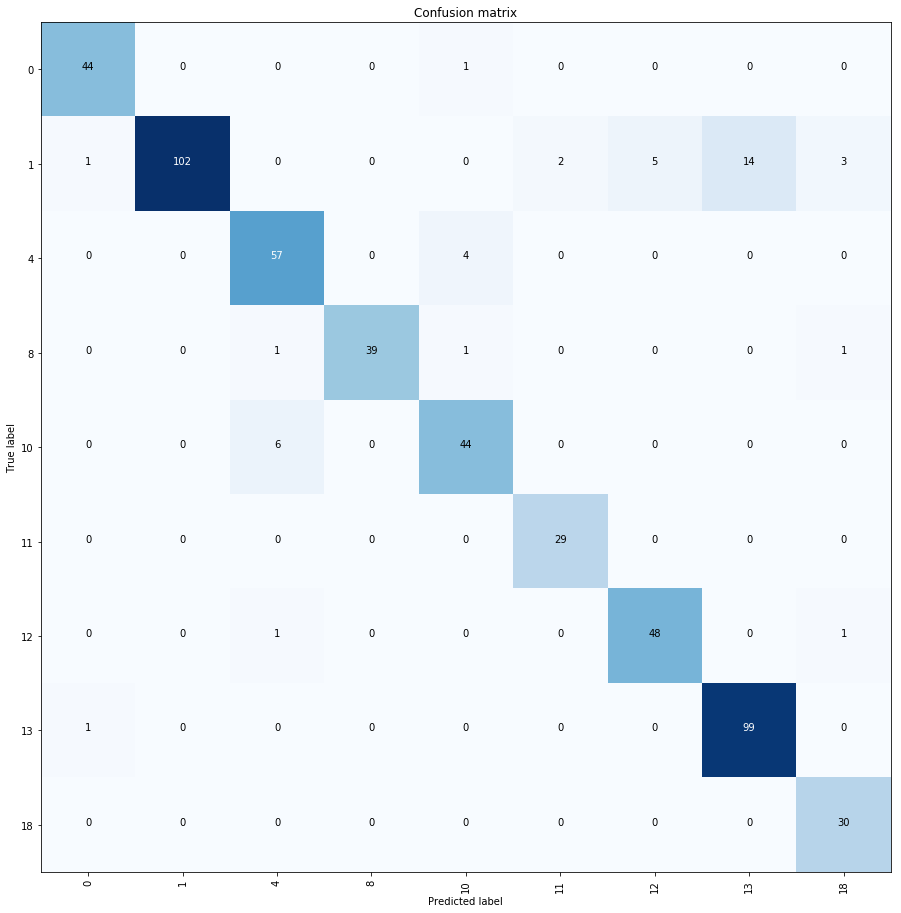


TESTING RESULTS


Accuracy:
0.52
              precision    recall  f1-score   support

           0       0.40      0.44      0.42         9
           1       0.69      0.31      0.43        29
           4       0.47      0.75      0.58        12
           8       0.00      0.00      0.00         7
          10       0.57      0.44      0.50         9
          11       0.33      0.40      0.36         5
          12       0.46      0.46      0.46        13
          13       0.67      0.91      0.77        22
          18       0.43      0.67      0.52         9

   micro avg       0.52      0.52      0.52       115
   macro avg       0.45      0.49      0.45       115
weighted avg       0.53      0.52      0.50       115



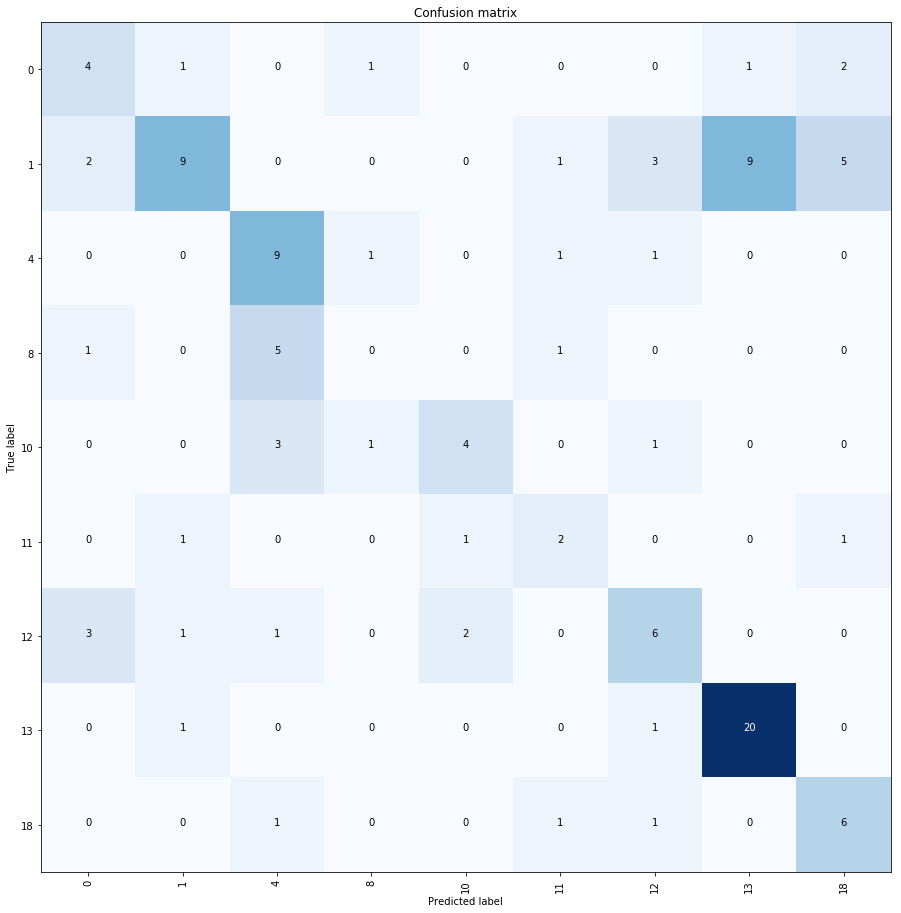

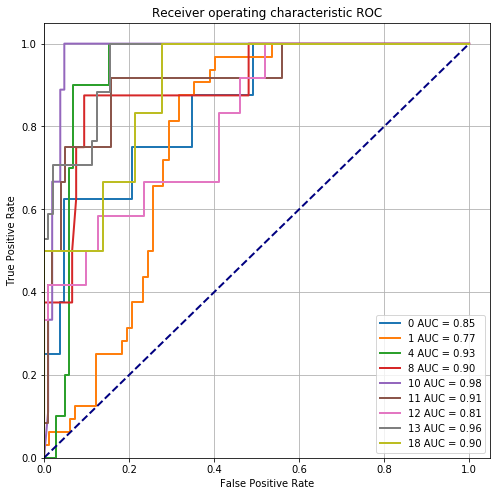

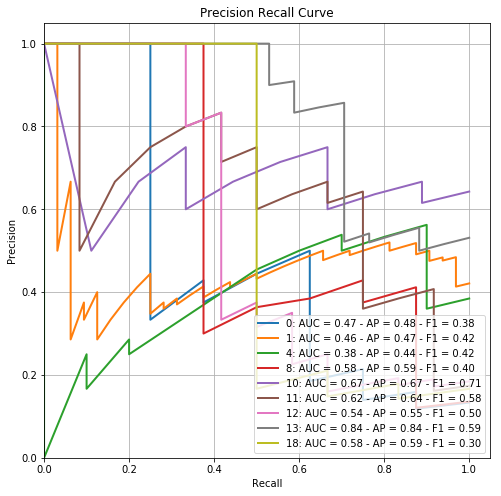


VALIDATION RESULTS

Threshold
[0.16, 0.13, 0.11, 0.15, 0.13, 0.11, 0.1, 0.17, 0.12]


class  false positive rate  true positive rate
0  0      0.047170             0.625000          
1  1      0.402439             0.968750          
2  4      0.153846             1.000000          
3  8      0.094340             0.875000          
4  10     0.047619             1.000000          
5  11     0.156863             0.916667          
6  12     0.519608             1.000000          
7  13     0.154639             1.000000          
8  18     0.277778             1.000000


TESTING RESULTS



class  false positive rate  true positive rate
0  0      0.000000             0.000000          
1  1      0.000000             0.000000          
2  4      0.019417             0.083333          
3  8      0.000000             0.000000          
4  10     0.000000             0.000000          
5  11     0.000000             0.000000          
6  12     0.000000             0.076923          
7  13     0.000000             0.000000          
8  18     0.028302             0.000000

In [54]:
ag_tip_tfidf = ShallowModel('tfidf')
ag_tip_tfidf._vectorizer = tfidf_vec
ag_tip_tfidf._preprocessing = preprocessing
ag_tip_tfidf.fit(data_cluster)

In [27]:
joblib.dump(ag_tip_tfidf,'model_classify_cluster.pkl')

['model_classify_cluster.pkl']

#### Vocab Words per Cluster

In [56]:
vocab_per_cluster = pd.DataFrame()
for cluster in clusters:
    vocab_per_cluster['Cluster {}: Words'.format(cluster)] = vocabulary(ag_tip_tfidf,cluster).feature.tolist()
    vocab_per_cluster['Cluster {}: Coeffs'.format(cluster)] = vocabulary(ag_tip_tfidf,cluster)[cluster].tolist()
vocab_per_cluster

Cluster 1: Words  Cluster 1: Coeffs Cluster 13: Words  \
0     el               1.08               no                 
1     ser que          0.90               me                 
2     un               0.89               el                 
3     ser              0.85               pero               
4     para             0.70               se                 
...    ...              ...               ..                 
2345  dia             -0.25               estas              
2346  estas           -0.26               como estas         
2347  que si          -0.28               lili               
2348  sala            -0.28               hablar             
2349  con             -0.37               con                

      Cluster 13: Coeffs Cluster 4: Words  Cluster 4: Coeffs  \
0     1.98                con              2.22                
1     1.66                con del          1.05                
2     1.39                leido            0.97                
3     1.19                leon             0.94                
4     1.13                con di           0.83                
...    ...                   ...            ...                
2345 -0.28                para            -0.83                
2346 -0.33                el              -0.84                
2347 -0.37                ser             -1.02                
2348 -0.37                un              -1.09                
2349 -0.41                la              -1.25                

     Cluster 12: Words  Cluster 12: Coeffs Cluster 10: Words  \
0     la                1.92                hablar             
1     000               1.42                con                
2     de la             1.24                hablar con         
3     00                1.10                muy                
4     del               0.97                vivi               
...   ...                ...                 ...               
2345  te               -0.45                por                
2346  no               -0.47                ticket             
2347  yo               -0.52                para               
2348  lili             -0.57                ser                
2349  con              -0.71                me                 

      Cluster 10: Coeffs Cluster 0: Words  Cluster 0: Coeffs Cluster 8: Words  \
0     1.80                que si           0.98               sala              
1     1.53                0000             0.93               cosa              
2     1.43                00000            0.90               lili              
3     1.39                ya te            0.77               bienes            
4     1.31                algo             0.76               hablar            
...    ...                 ...              ...                  ...            
2345 -0.55                lili            -0.60               si                
2346 -0.58                hablar con      -0.67               ser               
2347 -0.76                un              -0.80               el                
2348 -0.78                con             -0.81               la                
2349 -0.95                para            -1.13               para              

      Cluster 8: Coeffs Cluster 11: Words  Cluster 11: Coeffs  \
0     1.32               para solicitar    1.80                 
1     1.24               solicitar         1.55                 
2     1.24               para              1.53                 
3     1.22               cara              1.30                 
4     1.17               ticket de         1.10                 
...    ...                     ...          ...                 
2345 -0.54               si               -0.55                 
2346 -0.63               no               -0.56                 
2347 -0.79               hablar           -0.57                 
2348 -0.80               como             -0.75                 
2349 -1.16               ser      

In [29]:
vocab_per_cluster.to_excel('clusters_features.xlsx')

#### Word Cloud

In [57]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [60]:
def plot_word_cloud(data, cluster):
    wordcloud = WordCloud(max_font_size=50, max_words=200, background_color="white",width=700, height=400).generate(data)
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    wordcloud.to_file("word_clouds/{}.png".format(cluster))

Cluster 1


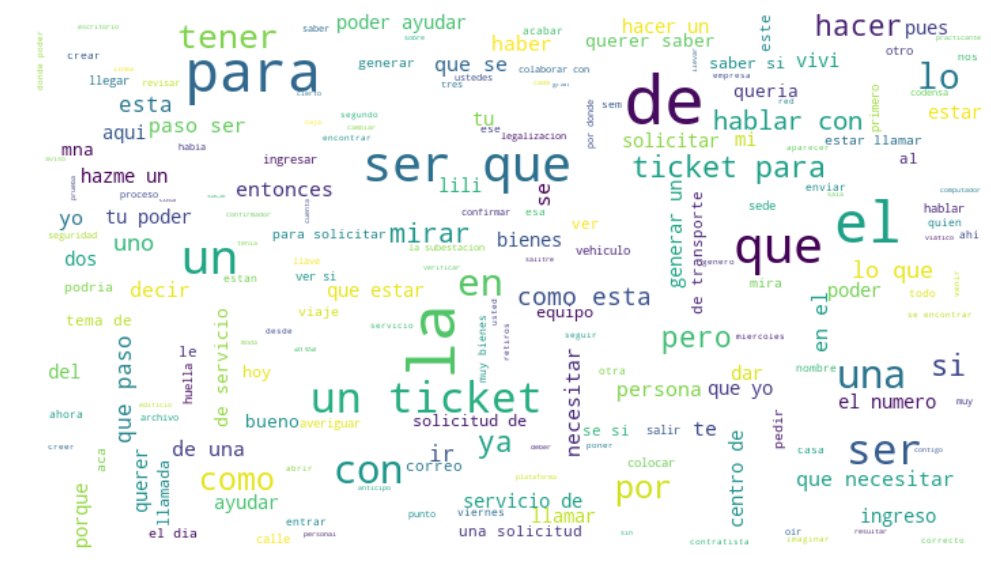

Cluster 13


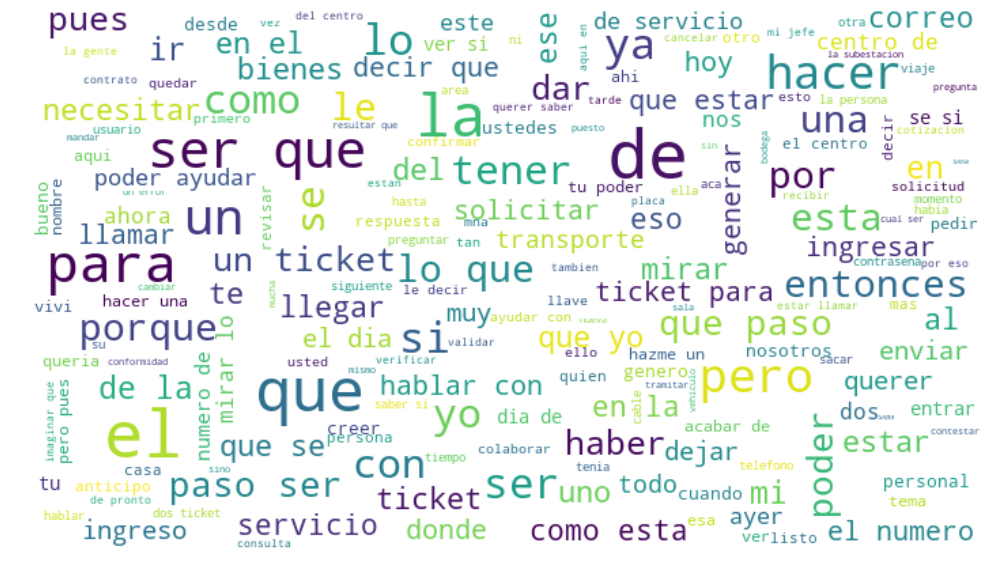

Cluster 4


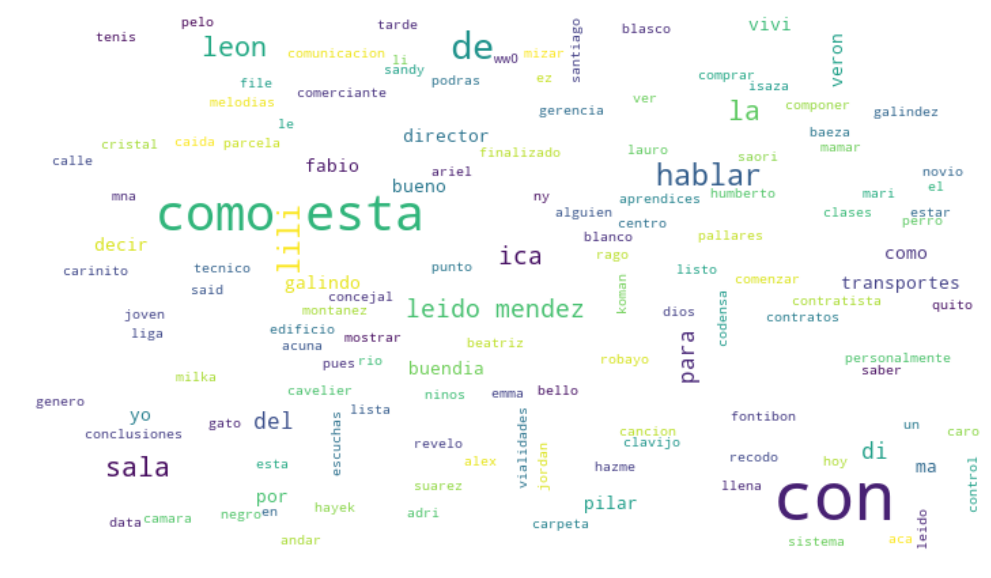

Cluster 12


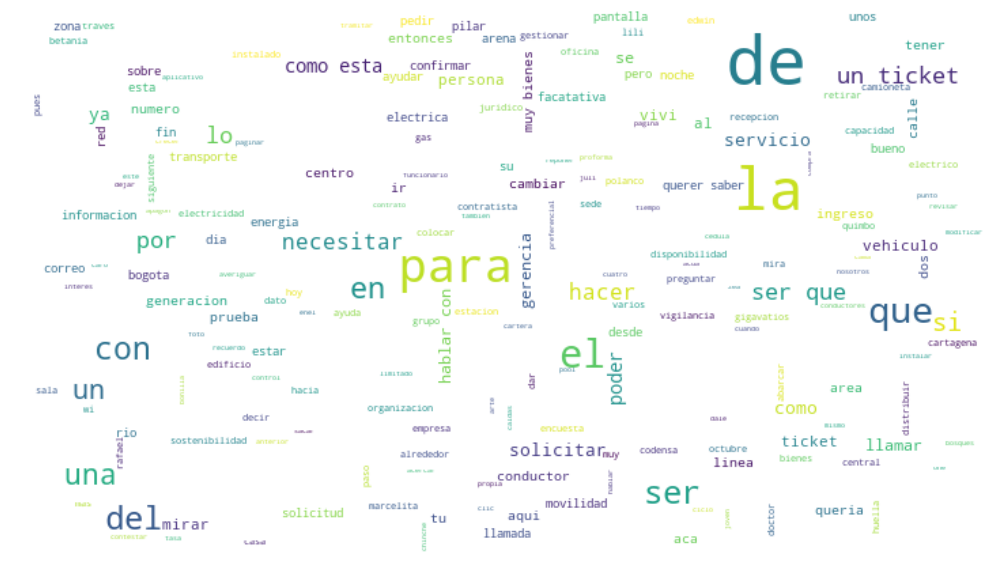

Cluster 10


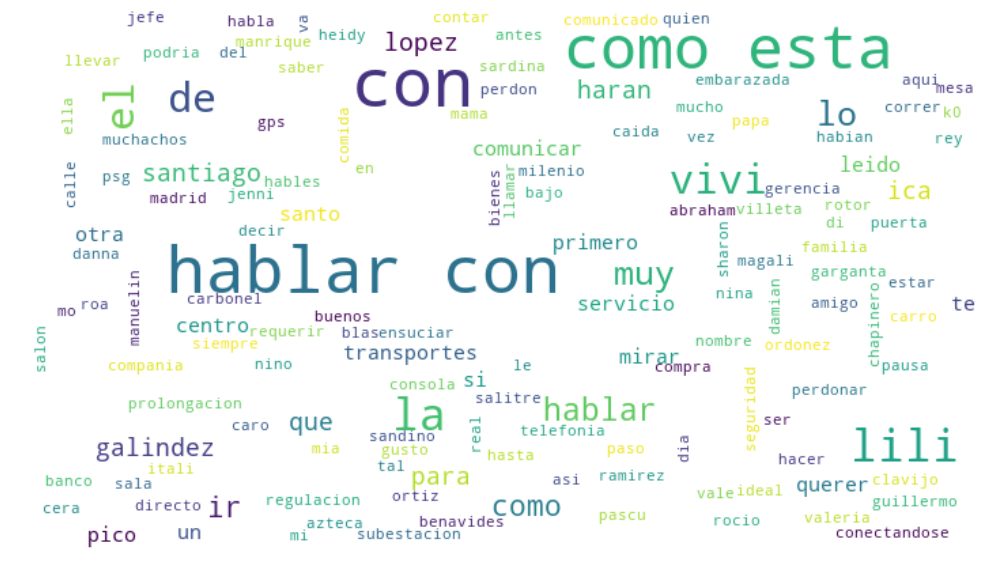

Cluster 0


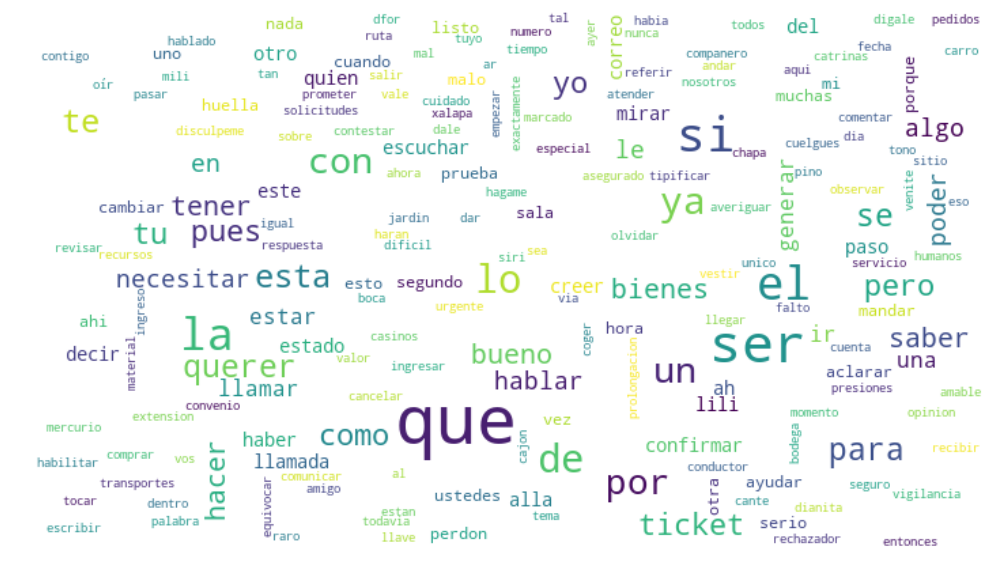

Cluster 8


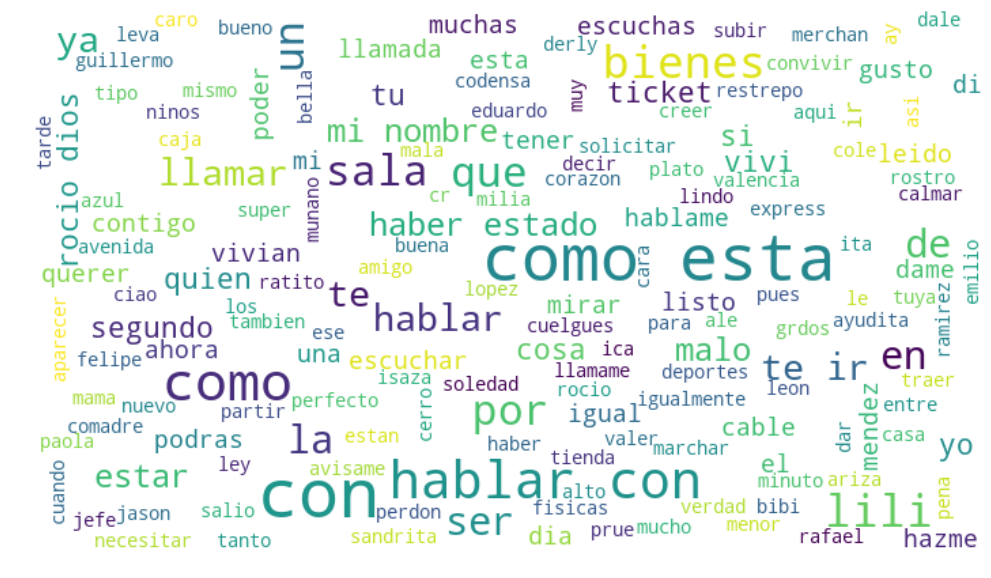

Cluster 11


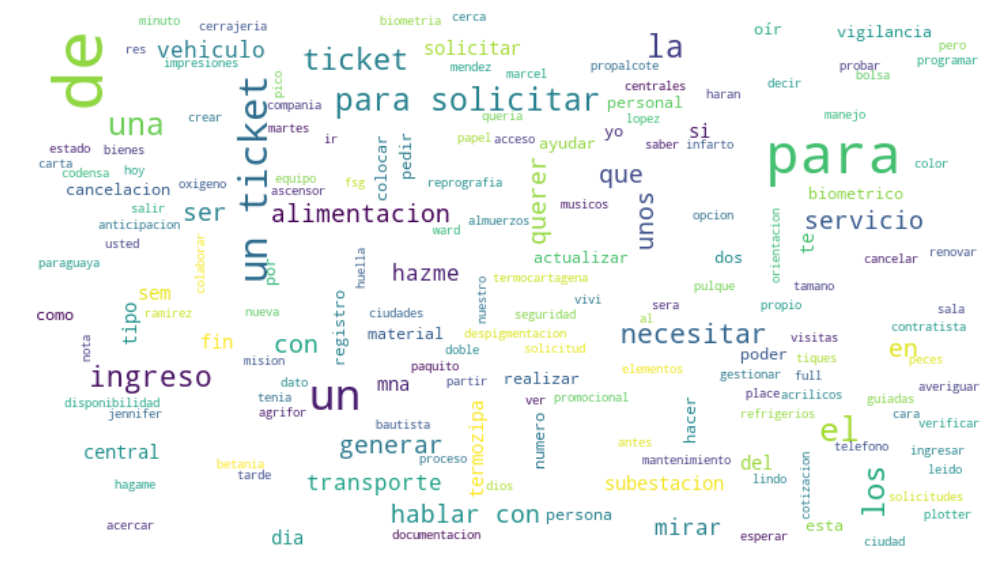

Cluster 18


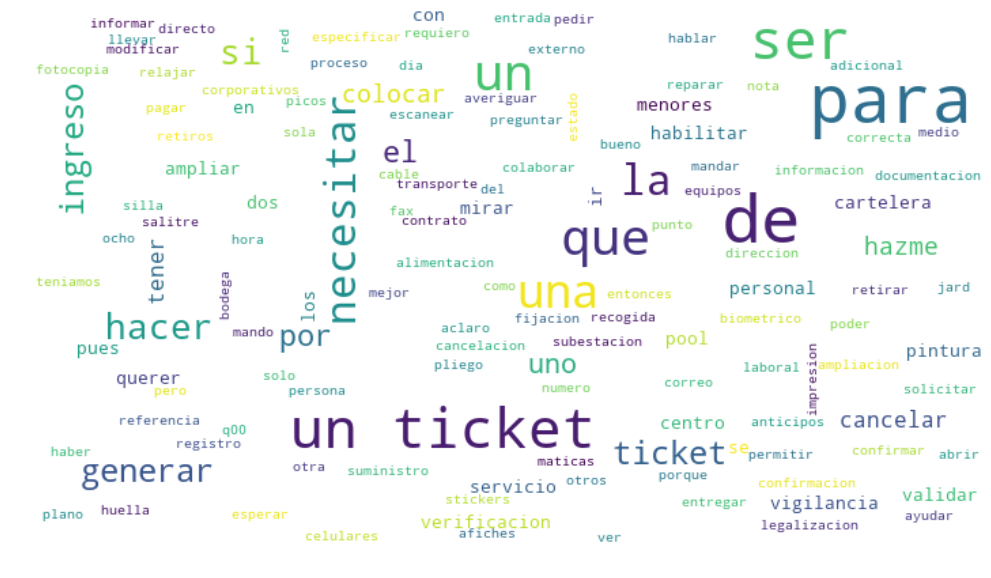

In [61]:
for i in clusters:
    print('Cluster {}'.format(i))
    plot_word_cloud(" ".join(review for review in data_cluster[data_cluster.label == i].iteration.tolist()),i)

### Training Model by Tickets

In [1]:
similarities = ['intermitente', 'titilar','intermitencia']

In [5]:
stri = ''
for word in similarities:
    stri +=  word + ' | '
stri

'intermitente | titilar | intermitencia | '

In [66]:
index_ticket = transcriptions_2_texts[transcriptions_2_texts.Transcript.str.contains(stri)]
index_no_ticket = transcriptions_2_texts[~transcriptions_2_texts.Transcript.str.contains('ticket')].index

In [68]:
index_ticket.shape, index_no_ticket.shape

((246,), (744,))

In [70]:
transcriptions_2_texts.loc[index_ticket,'cluster'] = 'ticket'
transcriptions_2_texts.loc[index_no_ticket,'cluster'] = 'no_ticket'

In [72]:
transcriptions_2_texts

Unnamed: 0  \
0    0            
1    1            
2    2            
3    3            
4    4            
5    5            
6    6            
7    7            
8    8            
9    9            
10   10           
11   11           
12   12           
13   13           
14   14           
15   15           
16   16           
17   17           
18   18           
19   19           
20   20           
21   21           
22   22           
23   23           
24   24           
25   25           
26   26           
27   27           
28   28           
29   29           
30   30           
31   31           
32   32           
33   33           
34   34           
35   35           
36   36           
37   37           
38   38           
39   39           
40   40           
41   41           
42   42           
43   43           
44   44           
45   45           
46   46           
47   47           
48   48           
49   49           
50   50           
51   51           
52   52           
53   53           
54   54           
55   55           
56   56           
57   57           
58   58           
59   59           
60   60           
61   61           
62   62           
63   63           
64   64           
65   65           
66   66           
67   67           
68   68           
69   69           
70   70           
71   71           
72   72           
73   73           
74   74           
75   75           
76   76           
77   77           
78   78           
79   79           
80   80           
81   81           
82   82           
83   83           
84   84           
85   85           
86   86           
87   87           
88   88           
89   89           
90   90           
91   91           
92   92           
93   93           
94   94           
95   95           
96   96           
97   97           
98   98           
99   99           
100  100          
101  101          
102  102          
103  103          
104  104          
105  105          
106  106          
107  107          
108  108          
109  109          
110  110          
111  111          
112  112          
113  113          
114  114          
115  115          
116  116          
117  117          
118  118          
119  119          
120  120          
121  121          
122  122          
123  123          
124  124          
125  125          
126  126          
127  127          
128  128          
129  129          
130  130          
131  131          
132  132          
133  133          
134  134          
135  135          
136  136          
137  137          
138  138          
139  139          
140  140          
141  141          
142  142          
143  143          
144  144          
145  145          
146  146          
147  147          
148  148          
149  149          
150  150          
151  151          
152  152          
153  153          
154  154          
155  155          
156  156          
157  157          
158  158          
159  159          
160  160          
161  161          
162  162          
163  163          
164  164          
165  165          
166  166          
167  167          
168  168          
169  169          
170  170          
171  171          
172  172          
173  173          
174  174          
175  175          
176  176          
177  177          
178  178          
179  179          
180  180          
181  181          
182  182          
183  183          
184  184          
185  185          
186  186          
187  187          
188  188          
189  189          
190  190          
191  191          
192  192          
193  193          
194  194          
195  195          
196  196          
197  197          
198  198          
199  199          
200  200          
201  201          
202  202          
203  203          
204  204          
205  205          
206  206          
207  207          
208  208          
209  209       

#### Training Model to Clasify

In [74]:
data_cluster = transcriptions_2_texts[['Transcript','cluster']].rename(columns = {'Transcript' : 'iteration', 'cluster' : 'label'})
data_cluster.shape

(990, 2)

In [75]:
counts = transcriptions_2_texts.cluster.value_counts().to_frame() 
percentage = (counts.cluster.values / counts.cluster.sum()) * 100
counts['percentage'] = percentage
counts

cluster  percentage
no_ticket  744      75.151515 
ticket     246      24.848485

In [ ]:
counts.to_excel('percentage_counts.xlsx')

In [83]:
tfidf_vec = TfidfVec()
tfidf_vec._embedding = TfidfVectorizer(ngram_range=(1,6),
                                       norm='l2',
                                       min_df=3,
                                       max_df=0.5,
                                       tokenizer=None,
                                       strip_accents=None,
                                       lowercase=False)

preprocessing = PreProc()
# preprocessing._stop_pos_words = []

/opt/conda/envs/nlp/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


100%|██████████| 990/990 [00:22<00:00, 44.85it/s]


Number of features: 1221


SPLIT

Size of training set: 693
Size of test set: 297
Size of training set: 148
Size of test set: 149

TRAINING RESULTS


Accuracy:
0.99
              precision    recall  f1-score   support

   no_ticket       1.00      0.99      0.99       511
      ticket       0.96      1.00      0.98       182

   micro avg       0.99      0.99      0.99       693
   macro avg       0.98      0.99      0.99       693
weighted avg       0.99      0.99      0.99       693



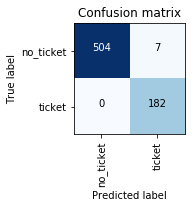


TESTING RESULTS


Accuracy:
0.95
              precision    recall  f1-score   support

   no_ticket       0.98      0.97      0.97       123
      ticket       0.85      0.88      0.87        26

   micro avg       0.95      0.95      0.95       149
   macro avg       0.91      0.93      0.92       149
weighted avg       0.95      0.95      0.95       149



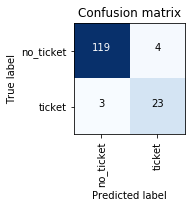

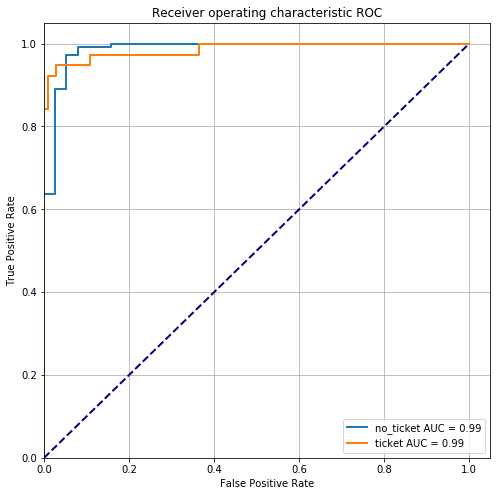

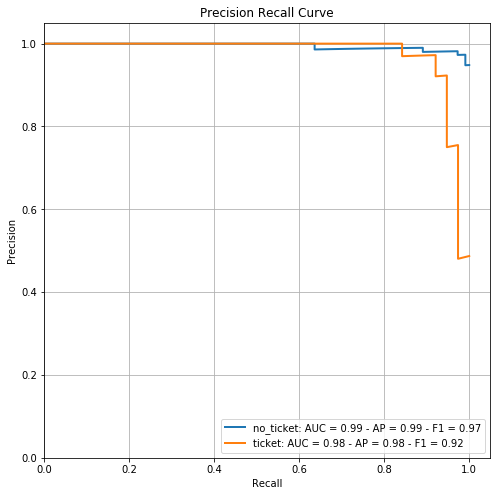


VALIDATION RESULTS

Threshold
[0.58, 0.43]


class  false positive rate  true positive rate
0  no_ticket  0.052632             0.972727          
1  ticket     0.027273             0.947368


TESTING RESULTS



class  false positive rate  true positive rate
0  no_ticket  0.115385             0.951220          
1  ticket     0.032520             0.884615

In [84]:
model_ticket = ShallowModel('tfidf')
model_ticket._vectorizer = tfidf_vec
model_ticket._preprocessing = preprocessing
model_ticket.fit(data_cluster)

In [ ]:
joblib.dump(model_ticket,'model_classify_cluster.pkl')

#### Vocab Words per Cluster

In [105]:
vocab = vocabulary(model_ticket,'ticket')
vocab

ticket                                  feature
0     5.91    ticket                                 
1     1.96    tickets                                
2     1.05    generar ticket                         
3     1.03    generar                                
4     0.99    hacer                                  
5     0.92    hacer ticket                           
6     0.90    solicitar ticket                       
7     0.85    ticket ingreso                         
8     0.85    ingreso                                
9     0.81    estar                                  
10    0.76    ser                                    
11    0.76    dos                                    
12    0.72    ser que                                
13    0.65    subestacion                            
14    0.64    tener ticket                           
15    0.63    colocar ticket                         
16    0.63    poder                                  
17    0.62    dos tickets                            
18    0.61    solicitar                              
19    0.60    mirar                                  
20    0.60    0000 00                                
21    0.59    colocar                                
22    0.56    tener                                  
23    0.55    porque                                 
24    0.54    reponer                                
25    0.54    hoy                                    
26    0.54    reponer ticket                         
27    0.54    ver                                    
28    0.53    dar                                    
29    0.53    estacion                               
30    0.51    ticket transporte                      
31    0.50    averiguar                              
32    0.50    estar llamar                           
33    0.49    que tener                              
34    0.48    transporte                             
35    0.47    red                                    
36    0.47    que                                    
37    0.47    ya                                     
38    0.47    no haber                               
39    0.47    llamar                                 
40    0.46    haber                                  
41    0.45    centro                                 
42    0.44    verificar                              
43    0.44    cancelacion                            
44    0.43    ticket que                             
45    0.42    ticket 0000                            
46    0.41    numero                                 
47    0.41    ser cancelacion                        
48    0.41    central                                
49    0.41    00                                     
50    0.40    necesitar generar                      
51    0.39    querer                                 
52    0.39    estado ticket                          
53    0.39    viaje                                  
54    0.39    necesitar hacer ticket                 
55    0.39    ser que tener                          
56    0.39    necesitar                              
57    0.38    necesitar generar ticket               
58    0.38    correcto                               
59    0.38    sede                                   
60    0.38    generacion                             
61    0.38    adicional                              
62    0.38    genero                                 
63    0.38    cancelar                               
64    0.37    ver si                                 
65    0.37    averiguar ticket                       
66    0.37    ser solicitar ticket                   
67    0.37    ticket servicio                        
68    0.36    tema                                   
69    0.36    estan                                  
70    0.36    pausa                                  
71    0.36    tickets alimentacion                   
72    0.35    centro servicio                        
73    0.35

In [106]:
vocab.to_excel('vocab_casa.xlsx')

#### Word Cloud

Cluster ticket


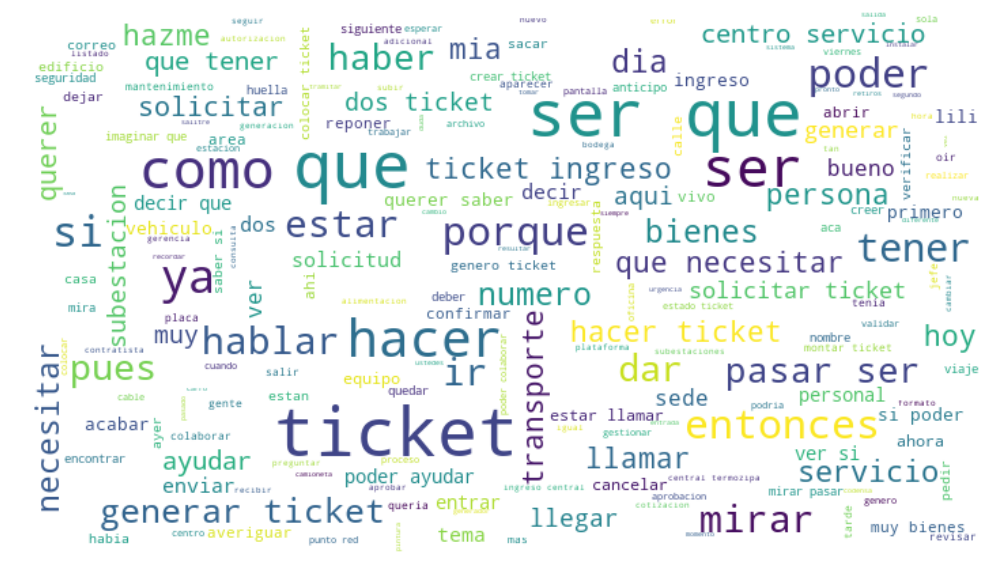

Cluster no_ticket


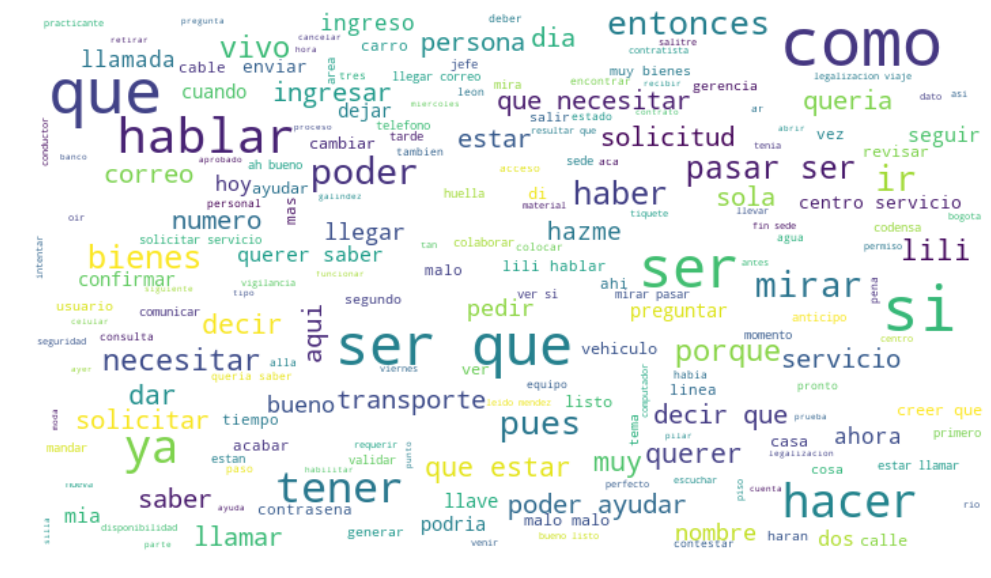

In [143]:
for i in ['ticket','no_ticket']:
    print('Cluster {}'.format(i))
    plot_word_cloud(" ".join(review for review in data_cluster[data_cluster.label == i].iteration.tolist()),i)

In [171]:
graph = create_adjacency_graph(data_set = data_cluster,
                               model = model_ticket,
                               label = 'ticket',
                               num_features = 60,
                               per_class = True,
                               levels = 2)
graph.render('context_words/ticket/generacion')

'context_words/ticket/generacion.pdf'

In [96]:
def interpretable_features(clust_prop, vocab, data, model):
    
    for cluster in clust_prop.index:
        os.mkdir('clusters/{}'.format(cluster))

    for cluster_number in clust_prop.index:
        not_done = True
        idx = 0

        while not_done:

            if vocab['Cluster {}: Coeffs'.format(cluster_number)].iloc[idx] > 0.99:
                graph = create_adjacency_graph(data_set = data,
                                           model = model,
                                           label = cluster_number,
                                           num_features = idx,
                                           per_class = True,
                                           levels = 2)
                graph.render('clusters/{}/{}'.format(cluster_number,
                                                     vocab['Cluster {}: Words'.format(cluster_number)].iloc[idx]))
                idx += 1
            else:
                not_done = False
                
interpretable_features(clust_prop = counts2, 
                       vocab = vocab_per_cluster_2, 
                       data = data_cluster2, 
                       model = ag_tip_tfidf)

### Counting Percentge Intentions

#### First Level

In [253]:
tickets_data = data_cluster[data_cluster.label == 'ticket']
tickets_data.shape

(246, 2)

In [254]:
cancelar = tickets_data[tickets_data.iteration.str.contains('cancelar|cancelacion')]
cancelar.shape

(12, 2)

In [255]:
estado = tickets_data[tickets_data.iteration.str.contains('estado|averiguar')]
estado.shape

(14, 2)

In [256]:
solicitud = tickets_data[tickets_data.iteration.str.contains('colocar|generar|hacer|solicitar|tener|reponer|abrir|genero|sacar|crear')]
solicitud.shape

(179, 2)

In [257]:
otro = tickets_data[~tickets_data.iteration.isin(solicitud.iteration.tolist() +
                                                 estado.iteration.tolist() +
                                                 cancelar.iteration.tolist())]
otro.shape

(54, 2)

In [263]:
idx = ['solicitud', 'otros varios', 'estado', 'cancelar', ]
result = pd.DataFrame([
                      solicitud.shape[0],
                      otro.shape[0],
                      estado.shape[0], 
                      cancelar.shape[0] 
                      ], columns = ['counts'])
result.index = idx
result['percentage'] = 100*(result.counts / result.counts.sum())
result = result.reset_index()
result.columns = ['Intenciones','counts', 'Porcentaje']
result

Intenciones  counts  Porcentaje
0  solicitud     179     69.111969 
1  otros varios  54      20.849421 
2  estado        14      5.405405  
3  cancelar      12      4.633205

In [260]:
result.to_excel('intenciones_ticket.xlsx', index = False)

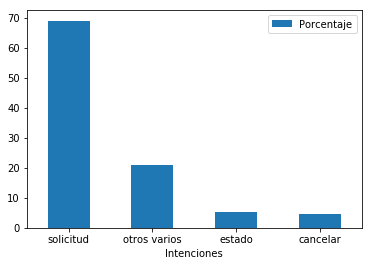

In [265]:
ax = result.plot.bar(x='Intenciones', y='Porcentaje', rot=0)

#### Second Level

In [236]:
transporte_sol = tickets_data[tickets_data.iteration.str.contains('transporte|transportes|vehiculo|vehiculos')]
transporte_sol.shape

(27, 2)

In [237]:
alimentacion_sol = tickets_data[tickets_data.iteration.str.contains('alimentacion')]
alimentacion_sol.shape

(5, 2)

In [238]:
ingreso_sol = tickets_data[tickets_data.iteration.str.contains('ingreso')]
ingreso_sol.shape

(36, 2)

In [239]:
mantenimiento_sol = tickets_data[tickets_data.iteration.str.contains('mantenimiento')]
mantenimiento_sol.shape

(7, 2)

In [240]:
materiales_sol = tickets_data[tickets_data.iteration.str.contains('materiales|material')]
materiales_sol.shape

(6, 2)

In [241]:
viaje_sol = tickets_data[tickets_data.iteration.str.contains('viaje')]
viaje_sol.shape

(6, 2)

In [242]:
equipo_sol = tickets_data[tickets_data.iteration.str.contains('equipo|equipos')]
equipo_sol.shape

(11, 2)

In [243]:
anticipo_sol = tickets_data[tickets_data.iteration.str.contains('anticipo')]
anticipo_sol.shape

(8, 2)

In [244]:
vigilancia_sol = tickets_data[tickets_data.iteration.str.contains('vigilancia')]
vigilancia_sol.shape

(4, 2)

In [245]:
cable_sol = tickets_data[tickets_data.iteration.str.contains('cable')]
cable_sol.shape

(7, 2)

In [246]:
plataforma_sol = tickets_data[tickets_data.iteration.str.contains('plataforma')]
plataforma_sol.shape

(4, 2)

In [247]:
punto_red_sol = tickets_data[tickets_data.iteration.str.contains('punto red')]
punto_red_sol.shape

(6, 2)

In [248]:
sala_sol = tickets_data[tickets_data.iteration.str.contains('sala|salas')]
sala_sol.shape

(1, 2)

In [249]:
pintura_sol = tickets_data[tickets_data.iteration.str.contains('pintura')]
pintura_sol.shape

(3, 2)

In [266]:
idx = ['transporte', 'alimentacion', 'ingreso', 'mantenimiento', 'materiales', 'viaje', 'equipo', 'anticipo',
       'vigilancia', 'cable', 'plataforma', 'punto_red', 'sala', 'pintura', 'otro']
result_sol = pd.DataFrame([transporte_sol.shape[0],
                       alimentacion_sol.shape[0],
                       ingreso_sol.shape[0],
                       mantenimiento_sol.shape[0], 
                       materiales_sol.shape[0],
                       viaje_sol.shape[0],
                       equipo_sol.shape[0],
                       anticipo_sol.shape[0],
                       vigilancia_sol.shape[0],
                       cable_sol.shape[0],
                       plataforma_sol.shape[0],
                       punto_red_sol.shape[0],
                       sala_sol.shape[0],
                       pintura_sol.shape[0],
                       not_found.shape[0]
                      ], columns = ['counts'])
result_sol.index = idx
result_sol['percentage'] = 100*(result_sol.counts / result_sol.counts.sum())
result_sol = result_sol.reset_index().sort_values(by=['percentage'], ascending = False)
result_sol.columns = ['Objeto Ticket','counts', 'Porcentaje']
result_sol

Objeto Ticket  counts  Porcentaje
14  otro           85      39.351852 
2   ingreso        36      16.666667 
0   transporte     27      12.500000 
6   equipo         11      5.092593  
7   anticipo       8       3.703704  
3   mantenimiento  7       3.240741  
9   cable          7       3.240741  
4   materiales     6       2.777778  
5   viaje          6       2.777778  
11  punto_red      6       2.777778  
1   alimentacion   5       2.314815  
8   vigilancia     4       1.851852  
10  plataforma     4       1.851852  
13  pintura        3       1.388889  
12  sala           1       0.462963

In [252]:
result_sol.to_excel('objectivos_tickets.xlsx', index = False)

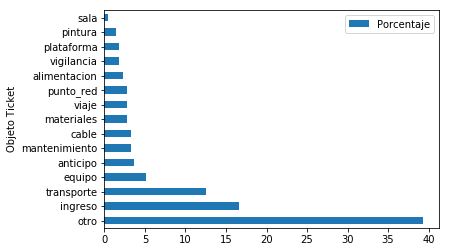

In [267]:
ax = result_sol.plot.barh(x='Objeto Ticket', y='Porcentaje', rot=0)

In [220]:
found = solicitud[solicitud.iteration.isin(transporte_sol.iteration.tolist() +
                                           alimentacion_sol.iteration.tolist() +
                                           ingreso_sol.iteration.tolist() +
                                           mantenimiento_sol.iteration.tolist() +
                                           materiales_sol.iteration.tolist() +
                                           viaje_sol.iteration.tolist() +
                                           equipo_sol.iteration.tolist() +
                                           anticipo_sol.iteration.tolist() +
                                           vigilancia_sol.iteration.tolist() +
                                           cable_sol.iteration.tolist() +
                                           plataforma_sol.iteration.tolist() +
                                           punto_red_sol.iteration.tolist() +
                                           sala_sol.iteration.tolist() +
                                           pintura_sol.iteration.tolist())]
found.shape

(94, 2)

In [221]:
not_found = solicitud[~solicitud.iteration.isin(transporte_sol.iteration.tolist() +
                                           alimentacion_sol.iteration.tolist() +
                                           ingreso_sol.iteration.tolist() +
                                           mantenimiento_sol.iteration.tolist() +
                                           materiales_sol.iteration.tolist() +
                                           viaje_sol.iteration.tolist() +
                                           equipo_sol.iteration.tolist() +
                                           anticipo_sol.iteration.tolist() +
                                           vigilancia_sol.iteration.tolist() +
                                           cable_sol.iteration.tolist() +
                                           plataforma_sol.iteration.tolist() +
                                           punto_red_sol.iteration.tolist() +
                                           sala_sol.iteration.tolist() +
                                           pintura_sol.iteration.tolist())]
not_found.shape

(85, 2)

#### Model

In [222]:
found['label'] = ['found']*found.shape[0]
not_found['label'] = ['not_found']*not_found.shape[0]

/opt/conda/envs/nlp/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/envs/nlp/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [223]:
new_data = pd.concat([found, not_found])
new_data

iteration  \
16   mirar nombre ser que no haber malentendidos persona mas ademas ser que tener problema ingreso personal dos subestaciones verificar ingreso hacer tickets momento tramitar error listado entonces dar antes tener que dar que pues que enviar correo casa dos tickets dos listado corregidos sacar dos tickets urgencia porque tener gente subestacion noroeste sol entrada subestacion mirar querer dejar entrar entonces que estar colaborar poder sacar dos tickets urgencia que no dejar entrar gente trabajar dia hoy invitar correo hacer 00 minuto 0 minuto                                                                                         
33   bienes mira ser que dia ayer solicitar transporte ser rechazador hoy noche mas tarde poder nuevo que ser servicio hoy 0 00 calle 00 numero ticket generar tarde 00 0000                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
36   solicitar ticket alimentacion                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
40   vivo edwin arenas ser que necesitar reponer ticket revisar dos punto red                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
47   hazme ser que necesitar solicitar ticket ingreso mia termozipa contratista                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
51   bienes llamada molestar saber si ayudar generacion tickets buena primero revisar centro servicio caqueza porque tener paredes muy osea que como dar caer como pintura pues ya ver muy feo                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
54   dia si ser que aca pasar ser que hacer poco generar ticket retiros equipos colaborador aqui sede l vigilante confirmador hacer que deber verif

In [224]:
tfidf_vec = TfidfVec()
tfidf_vec._embedding = TfidfVectorizer(ngram_range=(1,6),
                                       norm='l2',
                                       min_df=3,
                                       max_df=0.5,
                                       tokenizer=None,
                                       strip_accents=None,
                                       lowercase=False)

preprocessing = PreProc()

/opt/conda/envs/nlp/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


100%|██████████| 179/179 [00:04<00:00, 39.22it/s]


Number of features: 450


SPLIT

Size of training set: 125
Size of test set: 54
Size of training set: 27
Size of test set: 27

TRAINING RESULTS


Accuracy:
0.98
              precision    recall  f1-score   support

       found       1.00      0.95      0.97        61
   not_found       0.96      1.00      0.98        64

   micro avg       0.98      0.98      0.98       125
   macro avg       0.98      0.98      0.98       125
weighted avg       0.98      0.98      0.98       125



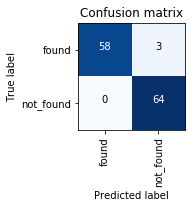


TESTING RESULTS


Accuracy:
0.74
              precision    recall  f1-score   support

       found       0.93      0.68      0.79        19
   not_found       0.54      0.88      0.67         8

   micro avg       0.74      0.74      0.74        27
   macro avg       0.73      0.78      0.73        27
weighted avg       0.81      0.74      0.75        27



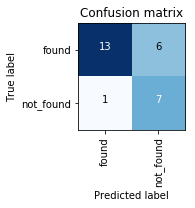

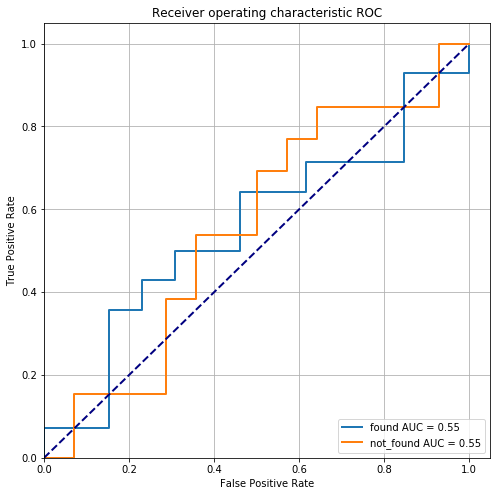

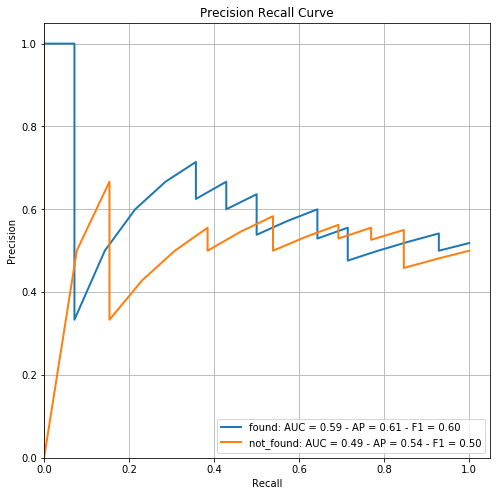


VALIDATION RESULTS

Threshold
[0.59, 0.44]


class  false positive rate  true positive rate
0  found      0.153846             0.357143          
1  not_found  0.642857             0.846154


TESTING RESULTS



class  false positive rate  true positive rate
0  found      0.125000             0.578947          
1  not_found  0.315789             0.875000

In [225]:
model_solicitud = ShallowModel('tfidf')
model_solicitud._vectorizer = tfidf_vec
model_solicitud._preprocessing = preprocessing
model_solicitud.fit(new_data)

#### Vocabulary

In [226]:
vocab_solicitud = vocabulary(model_solicitud,'not_found')
vocab_solicitud

not_found                                  feature
0    0.48       lili                                   
1    0.44       no poder                               
2    0.43       tener ticket                           
3    0.37       ir                                     
4    0.35       podria                                 
5    0.35       pedir                                  
6    0.34       generar                                
7    0.31       necesitar hacer ticket                 
8    0.31       000                                    
9    0.29       oir                                    
10   0.27       resultar                               
11   0.27       resultar que                           
12   0.27       hagame                                 
13   0.26       ahi                                    
14   0.26       archivo                                
15   0.26       no como                                
16   0.26       hacer ticket                           
17   0.26       tickets                                
18   0.25       correo                                 
19   0.24       colocar                                
20   0.24       llegar                                 
21   0.23       ver                                    
22   0.23       ticket servicio                        
23   0.23       servicio                               
24   0.23       colocar ticket                         
25   0.21       llevar                                 
26   0.21       enviar                                 
27   0.21       ayudar hacer                           
28   0.21       poder                                  
29   0.21       ayudar hacer ticket                    
30   0.20       respuesta                              
31   0.19       no haber                               
32   0.19       ser 00                                 
33   0.19       pasado                                 
34   0.19       asi                                    
35   0.18       generar ticket                         
36   0.18       bienes                                 
37   0.18       necesitar hacer                        
38   0.18       ticket ser                             
39   0.18       salir                                  
40   0.18       000 000                                
41   0.18       sacar                                  
42   0.17       no haber dar                           
43   0.17       bienes ser                             
44   0.17       solicitar ticket                       
45   0.17       bueno                                  
46   0.17       que solicitar                          
47   0.17       haber dar                              
48   0.17       0000                                   
49   0.16       dar respuesta                          
50   0.16       poder generar ticket                   
51   0.16       gran                                   
52   0.15       poder generar                          
53   0.15       salida                                 
54   0.15       tenia                                  
55   0.15       como ir                                
56   0.15       estar llamar                           
57   0.15       ticket numero                          
58   0.14       00000                                  
59   0.14       dejar                                  
60   0.14       que tener                              
61   0.14       que entrar                             
62   0.14       que ir                                 
63   0.14       pues no                                
64   0.14       ticket porque                          
65   0.14       escribir                               
66   0.14       que ayudar                             
67   0.13       no dejar                               
68   0.13       cuadrilla                              
69   0.13       genero                                 
70   0.13       siguiente    

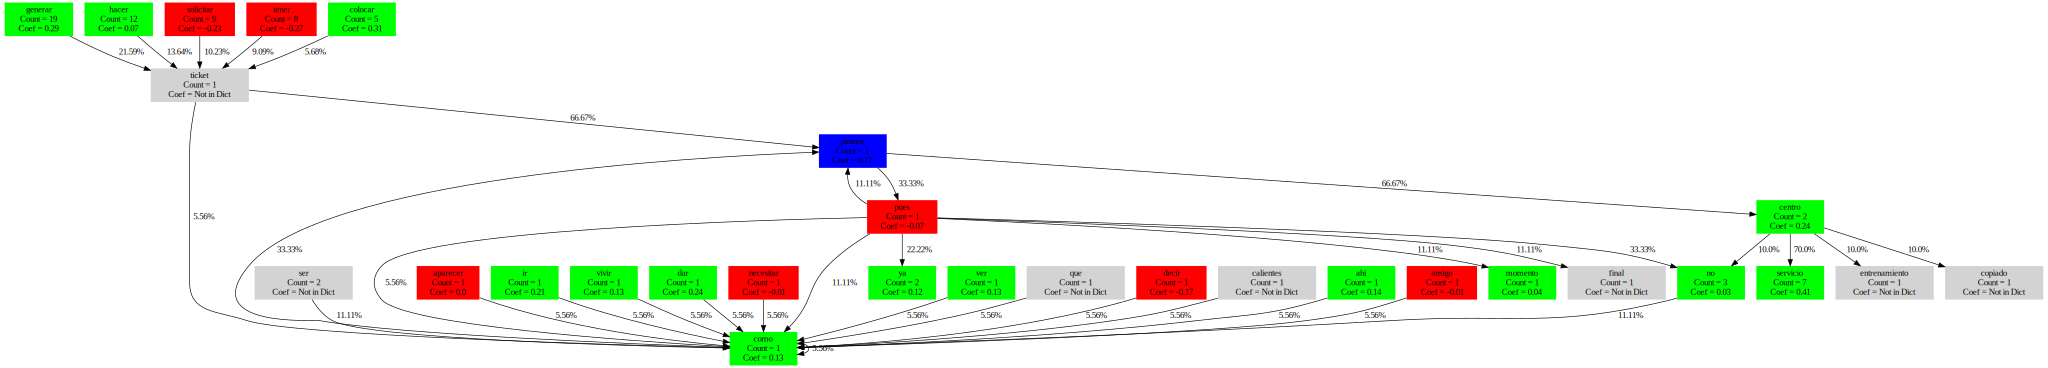

In [216]:
create_adjacency_graph(data_set = new_data,
                       model = model_solicitud,
                       label = 'not_found',
                       num_features = 43,
                       per_class = True,
                       levels = 2)
# graph.render('context_words/ticket/generacion')

In [1]:
from datetime import datetime

In [6]:
time = datetime.now()

In [5]:
time.

15